In [2]:
import os
import re
import unicodedata
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, f1_score, classification_report

from transformers import AutoTokenizer, AutoModel
from pythainlp.tokenize import word_tokenize

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import coalesce  

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import networkx as nx


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


part Import 

pip install --quiet transformers
pip install torch
pip install pandas
pip install pythainlp


Classes: {'‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á': 0, '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°': 1}

In [3]:
# =========================
# Load & clean data
# =========================
df = pd.read_csv('news_dataset_truefakenews.csv')
#df = df.rename(columns={'lable': 'label', 'autor': 'author'})


In [4]:
# ‡∏Å‡∏≥‡∏´‡∏ô‡∏î mapping dictionary
label_map = {
    '‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á': 'true',
    '‡∏Ñ‡∏•‡∏±‡∏á‡∏Ñ‡∏ß‡∏≤‡∏°‡∏£‡∏π‡πâ': 'true',
    '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°': 'fake',
    '‡∏≠‡∏≤‡∏ä‡∏ç‡∏≤‡∏Å‡∏£‡∏≠‡∏≠‡∏ô‡πÑ‡∏•‡∏ô‡πå': 'fake',
    '‡∏Ç‡πà‡∏≤‡∏ß‡∏ö‡∏¥‡∏î‡πÄ‡∏ö‡∏∑‡∏≠‡∏ô': 'fake',
    '‡∏Ç‡πà‡∏≤‡∏ß‡∏≠‡∏∑‡πà‡∏ô‡πÜ': None  # ‡∏•‡∏ö‡∏≠‡∏≠‡∏Å‡πÄ‡∏•‡∏¢
}
#print(f"category:{label_map['‡∏≠‡∏≤‡∏ä‡∏ç‡∏≤‡∏Å‡∏£‡∏≠‡∏≠‡∏ô‡πÑ‡∏•‡∏ô‡πå']}")

In [5]:
# ‡∏ó‡∏≥‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏∞‡∏≠‡∏≤‡∏î label ‡∏•‡∏ö‡∏≠‡∏¥‡πÇ‡∏°‡∏à‡∏¥ ‡πÅ‡∏•‡∏∞‡πÅ‡∏°‡∏õ‡∏Ñ‡πà‡∏≤ 
# Normalization Function

#‡∏•‡∏ö

# Remove zero-width characters  
ZW = ''.join(['\u200B', '\u200C', '\u200D', '\uFEFF'])


def normalize_thai(s):
    if pd.isna(s):
        return None
    #non-breaking space
    s = str(s).replace('\u00A0', ' ').translate({ord(ch): None for ch in ZW})
    s = unicodedata.normalize('NFC', s)
    s = re.sub(r'\s+', ' ', s).strip()
    # collapse repeated diacritics/marks
    s = re.sub(r'([\u0E31\u0E34-\u0E3A\u0E47-\u0E4E])\1+', r'\1', s)
    return s

df['label'] = df['label'].apply(normalize_thai) #print



#Map Label ‡πÉ‡∏´‡πâ‡πÄ‡∏õ‡πá‡∏ô‡∏Ñ‡∏•‡∏≤‡∏™‡∏ó‡∏µ‡πà‡∏ñ‡∏π‡∏Å‡∏ï‡πâ‡∏≠‡∏á
CANON = {'‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á': '‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á', '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°': '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°'}
ALIASES = {'‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏¥‡∏á': '‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á', '‡∏Ç‡πà‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á': '‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á', '‡∏Ç‡πà‡πà‡∏≤‡∏ß‡∏ö‡∏¥‡∏î‡πÄ‡∏ö‡∏∑‡∏≠‡∏ô': '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°'}

# ‡πÅ‡∏ó‡∏ô‡∏ó‡∏µ‡πà label ‡∏ó‡∏µ‡πà‡πÄ‡∏õ‡πá‡∏ô alias ‡πÉ‡∏´‡πâ‡πÄ‡∏õ‡πá‡∏ô canonical form?
df['label'] = df['label'].replace(ALIASES)
df = df[df['label'].isin(CANON.keys())].dropna(subset=['title', 'content']).reset_index(drop=True)



In [6]:
# # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå‡πÉ‡∏´‡∏°‡πà 'label_binary' ‡πÄ‡∏õ‡πá‡∏ô binary label ‡∏à‡∏≤‡∏Å mapping
# df['label_binary'] = df['label'].map(label_map)

# # ‡∏•‡∏ö‡πÅ‡∏ñ‡∏ß‡∏ó‡∏µ‡πà‡πÄ‡∏õ‡πá‡∏ô None (‡∏Ç‡πà‡∏≤‡∏ß‡∏≠‡∏∑‡πà‡∏ô‡πÜ)
# df = df.dropna(subset=['label_binary'])

# # ‡∏ñ‡πâ‡∏≤‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£ save ‡πÄ‡∏õ‡πá‡∏ô CSV ‡πÉ‡∏´‡∏°‡πà
# df.to_csv('news_dataset_truefakenews.csv', index=False)
#df.to_excel('news_dataset_truefakenews.xlsx', index=False)


# ‡∏î‡∏π‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå
print(df['title'].head(10))
print(df['content'].head(10))


0    OR ‡∏ä‡∏ß‡∏ô‡∏£‡πà‡∏ß‡∏°‡πÄ‡∏õ‡πá‡∏ô‡πÄ‡∏à‡πâ‡∏≤‡∏Ç‡∏≠‡∏á‡∏Å‡∏¥‡∏à‡∏Å‡∏≤‡∏£ ‡∏•‡∏á‡∏ó‡∏∏‡∏ô‡∏´‡∏∏‡πâ‡∏ô IPO ‡πÄ‡∏£‡∏¥‡πà...
1    ‡∏Å‡∏£‡∏∞‡∏ó‡∏£‡∏ß‡∏á‡∏¢‡∏∏‡∏ï‡∏¥‡∏ò‡∏£‡∏£‡∏° ‡πÄ‡∏õ‡∏¥‡∏î‡πÄ‡∏û‡∏à‡πÄ‡∏ü‡∏ã‡∏ö‡∏∏‡πä‡∏Å‡∏ä‡∏∑‡πà‡∏≠ Technology ...
2    ‡∏´‡∏∏‡πâ‡∏ô OKJ ‡πÄ‡∏õ‡∏¥‡∏î‡πÄ‡∏ó‡∏£‡∏î‡∏ß‡∏±‡∏ô‡πÅ‡∏£‡∏Å ‡∏£‡∏≤‡∏Ñ‡∏≤‡πÄ‡∏õ‡∏¥‡∏î‡∏û‡∏≠‡∏£‡πå‡∏ï‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ï‡πâ‡∏ô ...
3    ‡∏Å‡∏£‡∏∏‡∏á‡πÑ‡∏ó‡∏¢ ‡πÄ‡∏õ‡∏¥‡∏î‡πÉ‡∏´‡πâ‡∏à‡∏≠‡∏á‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡πå‡∏¢‡∏∑‡∏°‡πÄ‡∏á‡∏¥‡∏ô 100,000 ‡∏ö‡∏≤‡∏ó ‡∏•‡∏á...
4              ‡∏Å.‡∏•.‡∏ï. ‡πÄ‡∏õ‡∏¥‡∏î‡πÄ‡∏ß‡πá‡∏ö‡πÑ‡∏ã‡∏ï‡πå‡πÉ‡∏´‡πâ‡∏ú‡∏π‡πâ‡∏•‡∏á‡∏ó‡∏∏‡∏ô‡∏™‡∏∞‡∏™‡∏°‡∏Ñ‡∏∞‡πÅ‡∏ô‡∏ô
5    ‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°‡∏£‡∏±‡∏ö‡∏°‡∏∑‡∏≠ ‡∏û‡∏≤‡∏¢‡∏∏‡∏ß‡∏¥‡∏†‡∏≤ ‡πÄ‡∏Ç‡πâ‡∏≤‡πÑ‡∏ó‡∏¢ ‡∏®‡∏π‡∏ô‡∏¢‡πå‡∏Å‡∏•‡∏≤‡∏á‡∏ú‡πà‡∏≤‡∏ô ‡∏à....
6    ‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà 23 ‡∏Å.‡∏Ñ. 68 ‡∏à‡∏∞‡πÄ‡∏Å‡∏¥‡∏î‡∏õ‡∏£‡∏≤‡∏Å‡∏è‡∏Å‡∏≤‡∏£‡∏ì‡πå Red Rain ‡∏ñ‡∏•...
7    ‡∏≠‡∏≠‡∏°‡∏™‡∏¥‡∏ô‡πÄ‡∏õ‡∏¥‡∏î‡∏™‡∏¥‡∏ô‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡πÉ‡∏´‡πâ‡∏¢‡∏∑‡∏° ‡∏ú‡πà‡∏≤‡∏ô‡πÄ‡∏û‡∏à LEASE it PCL ...
8     

In [7]:
#  ‡∏ï‡∏±‡∏î‡∏Ñ‡∏≥  PyThaiNLP

#def thai_tokenize(text):
def thai_token_list(text):
    if pd.isna(text):
        return []
    return word_tokenize(text, engine='newmm', keep_whitespace=False)

#‡πÄ‡∏Å‡πá‡∏ö‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå‡∏Å‡∏≤‡∏£‡∏ï‡∏±‡∏î‡∏Ñ‡∏≥‡πÉ‡∏ô‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå‡πÉ‡∏´‡∏°‡πà‡πÉ‡∏ô DataFrame
df['title_tokens'] = df['title'].apply(thai_token_list)
df['content_tokens'] = df['content'].apply(thai_token_list)

In [8]:
#‡∏´‡∏ô‡πâ‡∏≤‡∏ï‡∏≤‡∏´‡∏•‡∏±‡∏á‡∏ï‡∏±‡∏î‡∏Ñ‡∏≥
# print(df['title'].head(10))
# print(df['title_tokens'].head(10))
# print(df['content'].head(10))
# print(df['content_tokens'].head(10))

In [9]:
# ‡πÇ‡∏´‡∏•‡∏î‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏†‡∏≤‡∏©‡∏≤‡πÑ‡∏ó‡∏¢ + ‡∏à‡∏±‡∏î device WangchanBERTa
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

#WangchanBERTa
lm_model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#‡∏¢‡πâ‡∏≤‡∏¢‡πÑ‡∏õdevice    
lm_model = lm_model.to(device).eval()


In [10]:
#‡∏Å‡∏≥‡∏´‡∏ô‡∏î‡πÅ‡∏•‡∏∞‡∏Ñ‡∏á‡∏Ñ‡πà‡∏≤‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏±‡∏°‡∏û‡∏±‡∏ô‡∏ò‡πå‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á label ‡∏Å‡∏±‡∏ö‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç
#  Mapping ‡∏à‡∏≤‡∏Å label ‚Üí ‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç
label2id = {'‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á': 0, '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°': 1}
# Mapping ‡∏à‡∏≤‡∏Å‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç ‚Üí label
id2label = {v: k for k, v in label2id.items()}

Dataset Size: 938 | ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á: 345, ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°: 593


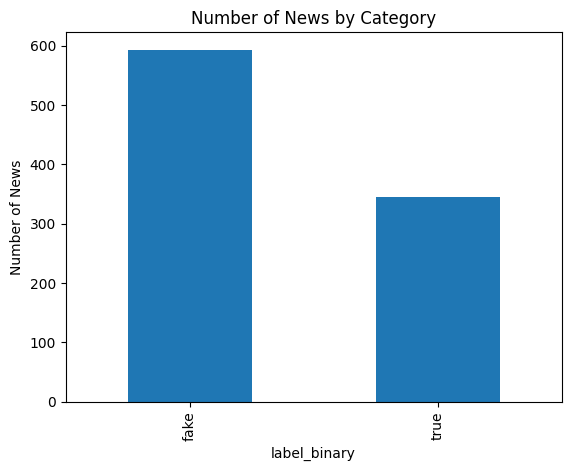

In [11]:
# ‡∏™‡∏£‡∏∏‡∏õ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏ö‡∏∑‡πâ‡∏≠‡∏á‡∏ï‡πâ‡∏ô‡∏Ç‡∏≠‡∏á‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏Ç‡πà‡∏≤‡∏ß‡πÉ‡∏ô‡πÅ‡∏ï‡πà‡∏•‡∏∞‡∏Ñ‡∏•‡∏≤‡∏™
num_true = (df['label_binary'] == 'true').sum()
num_fake = (df['label_binary'] == 'fake').sum()

print(f"Dataset Size: {len(df)} | ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á: {num_true}, ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°: {num_fake}")

# ‡∏Å‡∏£‡∏≤‡∏ü‡πÅ‡∏ó‡πà‡∏á‡πÅ‡∏™‡∏î‡∏á‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏Ç‡πà‡∏≤‡∏ß‡πÉ‡∏ô‡πÅ‡∏ï‡πà‡∏•‡∏∞‡∏Ñ‡∏•‡∏≤‡∏™
try:
    df['label_binary'].value_counts().plot(kind='bar')
    plt.title('Number of News by Category')
    plt.ylabel('Number of News')
    plt.show()
except Exception as e:
    print("Plot skipped:", e)

#  Thai tokenization stats (not used in BERT input)
df['title_tokens'] = df['title'].apply(thai_token_list)
df['content_tokens'] = df['content'].apply(thai_token_list)



In [12]:
# ‡∏î‡∏π‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á tokenized titles and content
print("Sample of tokenized titles:")
print(df[['title', 'title_tokens']].head(1))

print("\nSample of tokenized content:")
print(df[['content', 'content_tokens']].head(1))

# Print token len().mean() statistic
print("\nToken statistics:")
print(f"Average tokens in titles: {df['title_tokens'].str.len().mean():.2f}")
print(f"Average tokens in content: {df['content_tokens'].str.len().mean():.2f}")

#--- TRUE NEWS SAMPLES ---
print("\nSample of true news title:")
print(df[df['label_binary'] == 'true'][['title', 'label_binary']].head(2))


#--- FAKE NEWS SAMPLES ---
print("\nSample of fake news title:")
print(df[df['label_binary'] == 'fake'][['title', 'label_binary']].head(2))

Sample of tokenized titles:
                                               title  \
0  OR ‡∏ä‡∏ß‡∏ô‡∏£‡πà‡∏ß‡∏°‡πÄ‡∏õ‡πá‡∏ô‡πÄ‡∏à‡πâ‡∏≤‡∏Ç‡∏≠‡∏á‡∏Å‡∏¥‡∏à‡∏Å‡∏≤‡∏£ ‡∏•‡∏á‡∏ó‡∏∏‡∏ô‡∏´‡∏∏‡πâ‡∏ô IPO ‡πÄ‡∏£‡∏¥‡πà...   

                                        title_tokens  
0  [OR, ‡∏ä‡∏ß‡∏ô, ‡∏£‡πà‡∏ß‡∏°, ‡πÄ‡∏õ‡πá‡∏ô, ‡πÄ‡∏à‡πâ‡∏≤‡∏Ç‡∏≠‡∏á‡∏Å‡∏¥‡∏à‡∏Å‡∏≤‡∏£, ‡∏•‡∏á‡∏ó‡∏∏‡∏ô, ‡∏´‡∏∏...  

Sample of tokenized content:
                                             content  \
0  ‡∏à‡∏≤‡∏Å‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Å‡∏≤‡∏£‡πÇ‡∏Ü‡∏©‡∏ì‡∏≤‡∏£‡∏∞‡∏ö‡∏∏‡πÄ‡∏õ‡∏¥‡∏î‡πÉ‡∏´‡πâ‡∏•‡∏á‡∏ó‡∏∏‡∏ô‡∏´‡∏∏‡πâ‡∏ô IPO ‡∏Ç‡πâ‡∏≤‡∏á‡∏ï...   

                                      content_tokens  
0  [‡∏à‡∏≤‡∏Å, ‡∏ó‡∏µ‡πà, ‡∏°‡∏µ, ‡∏Å‡∏≤‡∏£, ‡πÇ‡∏Ü‡∏©‡∏ì‡∏≤, ‡∏£‡∏∞‡∏ö‡∏∏, ‡πÄ‡∏õ‡∏¥‡∏î, ‡πÉ‡∏´‡πâ, ‡∏•‡∏á...  

Token statistics:
Average tokens in titles: 11.80
Average tokens in content: 113.36

Sample of true news title:
                                              title label_binary
8  ‡∏Å‡∏¢‡∏®. ‡πÄ‡∏£‡πà‡∏á‡∏Ñ‡∏∑‡∏ô‡πÄ‡∏á‡

In [13]:
# -------------------------------------------
#  ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏™‡∏£‡πâ‡∏≤‡∏á BERT Embedding WangchanBERT 
# -------------------------------------------
#Decorator
@torch.no_grad()
def get_bert_embedding_from_text(text, max_length=256, use_mean_pool=True):
    """
    Return numpy vector for text using WangchanBERT
    """
    if pd.isna(text):
        text = ""
    
    # Tokenize input
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    ).to(device)
    
    # Forward ‡∏ú‡πà‡∏≤‡∏ô BERT
    outputs = lm_model(**inputs)
    
    # Mean pooling
    if use_mean_pool:
        attn = inputs['attention_mask'].unsqueeze(-1)
        summed = (outputs.last_hidden_state * attn).sum(dim=1)
        denom = attn.sum(dim=1).clamp(min=1)
        emb = (summed / denom).squeeze(0).cpu().numpy()
    else:
        # ‡πÉ‡∏ä‡πâ CLS token
        emb = outputs.last_hidden_state[:,0,:].squeeze(0).cpu().numpy()
    
    return emb

    

tensor

In [14]:
#  Embeddings to vectors
print("\nCreating BERT Embeddings for Title and Content...")
title_emb = np.vstack([get_bert_embedding_from_text(text, use_mean_pool=True) for text in df['title']])
content_emb = np.vstack([get_bert_embedding_from_text(text, use_mean_pool=True) for text in df['content']])

# Concatenate and Normalize
#‡∏£‡∏ß‡∏°
x_np = np.hstack([title_emb, content_emb]) # shape (N, 1536)
x_np = normalize(x_np, axis=1, norm='l2')
y_np = df['label'].map(label2id).values

#show shape
print(f"Combined embedding shape (x_np): {x_np.shape}")

#show example
print(pd.DataFrame(x_np).head(5))
print("x_np shape:", x_np.shape)
print("Example vector (first 10 dims):", x_np[0][:10], "...")



Creating BERT Embeddings for Title and Content...


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Combined embedding shape (x_np): (938, 1536)
       0         1         2         3         4         5         6     \
0  0.009440 -0.055937  0.010781  0.009715 -0.020595 -0.016658  0.038007   
1 -0.018866 -0.013389  0.029290  0.028072 -0.023694  0.024845 -0.002467   
2 -0.004297 -0.054674  0.006164  0.025670 -0.008726 -0.025533  0.022739   
3 -0.004038 -0.037407  0.017466  0.014555 -0.016643  0.004019  0.036810   
4  0.050563  0.012704 -0.000594  0.020924  0.015106  0.027066  0.027630   

       7         8         9     ...      1526      1527      1528      1529  \
0 -0.002626 -0.004493  0.001407  ... -0.011996  0.003064  0.017463  0.001360   
1 -0.008415  0.002117 -0.026758  ...  0.012361  0.004698  0.013069  0.012872   
2 -0.017483 -0.005550  0.017755  ...  0.000092 -0.000812  0.001738  0.010710   
3 -0.022862 -0.012967  0.014511  ...  0.004602  0.002643  0.001115  0.022412   
4  0.013650  0.021515  0.013401  ... -0.005073  0.000831  0.013191 -0.001225   

       1530      1531  

‡∏´‡∏ô‡πâ‡∏≤‡∏ï‡∏≤‡πÄ‡∏õ‡πá‡∏ô‡πÑ‡∏á ‡πÉ‡∏ä‡πâ‡∏™‡∏π‡∏ï‡∏£‡∏≠‡∏∞‡πÑ‡∏£

In [15]:
# ‡∏î‡∏π‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á DataFrame ‡∏Ç‡∏≠‡∏á Embedding
pd.DataFrame(x_np).head()

print(x_np.shape)   # ‡∏î‡∏π‡∏Ç‡∏ô‡∏≤‡∏î ‡πÄ‡∏ä‡πà‡∏ô (‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏≠‡∏Å‡∏™‡∏≤‡∏£, ‡∏Ç‡∏ô‡∏≤‡∏î‡πÄ‡∏ß‡∏Å‡πÄ‡∏ï‡∏≠‡∏£‡πå)
print(x_np[0])      # ‡∏î‡∏π embedding ‡∏Ç‡∏≠‡∏á‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡πÅ‡∏£‡∏Å


(938, 1536)
[ 0.00943962 -0.05593715  0.01078102 ... -0.00691378  0.03518404
  0.01866273]


‡πÄ‡∏™‡∏£‡πá‡∏à embedding //‡∏ó‡∏≥‡πÑ‡∏°‡∏à‡∏∏‡∏î‡πÄ‡∏õ‡πá‡∏ô‡πÅ‡∏ö‡∏ö‡∏ô‡∏µ‡πâ

In [16]:

# ‡πÅ‡∏õ‡∏•‡∏á labels -> ‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç
classes = sorted(df['label'].unique())
label2id = {c:i for i,c in enumerate(classes)}
y_np = df['label'].map(label2id).values
print(f"Classes: {label2id}")

Classes: {'‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á': 0, '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°': 1}


In [17]:
# ====================================================================
# kNN Graph Construction
# ====================================================================
k=8
N = x_np.shape[0]
print(f"\n--- Building kNN Graph with k={k} ---")

# 1. Fit kNN (‡πÄ‡∏Å‡πá‡∏ö nbrs ‡πÑ‡∏ß‡πâ‡πÉ‡∏ä‡πâ‡πÉ‡∏ô predict_news)
nbrs = NearestNeighbors(n_neighbors=k + 1, metric='cosine').fit(x_np) 
dist, idx = nbrs.kneighbors(x_np) 

# 2. Create edges and weights (directed)
src = np.repeat(np.arange(N), k)
dst = idx[:, 1:].reshape(-1)
w = 1.0 - dist[:, 1:].reshape(-1) 

# 3. Make undirected
edge_index_np = np.vstack([src, dst])
edge_index_np_rev = edge_index_np[::-1, :]
edge_index_np = np.concatenate([edge_index_np, edge_index_np_rev], axis=1)
edge_weight_np = np.concatenate([w, w], axis=0)

edge_index = torch.tensor(edge_index_np, dtype=torch.long)
edge_weight = torch.tensor(edge_weight_np, dtype=torch.float)

# 4. Coalesce
try:
    edge_index, edge_weight = coalesce(edge_index, edge_weight, N, reduce='mean')
except Exception as e: 
    print(f"Warning: coalesce failed ({e}), proceeding without coalesce.")


--- Building kNN Graph with k=8 ---


In [18]:
# ====================================================================
#  Create PyG Data and Train/Val/Test splits
# ====================================================================
x = torch.tensor(x_np, dtype=torch.float)
y = torch.tensor(y_np, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y, edge_weight=edge_weight).to(device)

# 70/15/15 split
idx_all = np.arange(N)
idx_train, idx_test = train_test_split(idx_all, test_size=0.15, stratify=y_np, random_state=42)
idx_train, idx_val = train_test_split(idx_train, test_size=0.1765, stratify=y_np[idx_train], random_state=42)

train_mask = torch.zeros(N, dtype=torch.bool, device=device); train_mask[idx_train] = True
val_mask = torch.zeros(N, dtype=torch.bool, device=device); val_mask[idx_val] = True
test_mask = torch.zeros(N, dtype=torch.bool, device=device); test_mask[idx_test] = True
data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask

print(f"Train size: {train_mask.sum().item()}, Val size: {val_mask.sum().item()}, Test size: {test_mask.sum().item()}")

Train size: 656, Val size: 141, Test size: 141


In [19]:
# ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö label distribution
print(y_np)  # ‡πÅ‡∏™‡∏î‡∏á‡∏Ñ‡πà‡∏≤‡∏ó‡∏∏‡∏Å‡∏≠‡∏±‡∏ô
print(np.unique(y_np, return_counts=True))  

[1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0
 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1
 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0
 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1
 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1
 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0
 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 0 1 

In [20]:
# ====================================================================
# GCN Model Definition and Evaluation Function
# ====================================================================
class GCNNet(nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=256, dropout_rate=0.4):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, getattr(data, 'edge_weight', None)
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x # logits

def evaluate_masked(logits, mask, data):
    y_true = data.y[mask].cpu().numpy()
    y_pred = logits[mask].argmax(dim=1).cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return acc, f1m

In [21]:
# ====================================================================
# Training Setup and Loop
# ====================================================================
NUM_NODE_FEATURES = data.x.shape[1]
NUM_CLASSES = len(label2id)
LR_RATE = 1e-3
WEIGHT_DECAY = 5e-4
PATIENCE_LIMIT = 30
SCHEDULER_PATIENCE = 15
num_epochs = 500

model_gnn = GCNNet(num_node_features=NUM_NODE_FEATURES, num_classes=NUM_CLASSES).to(device)

# Class weights from train set
cls_count = np.bincount(y_np[idx_train], minlength=NUM_CLASSES).astype(np.float32)
cls_w = torch.tensor((cls_count.sum() / (cls_count + 1e-9)), dtype=torch.float, device=device)
cls_w = cls_w / cls_w.mean()

opt = torch.optim.Adam(model_gnn.parameters(), lr=LR_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=SCHEDULER_PATIENCE)

best_val_f1, best_state, best_epoch = -1.0, None, 0
patience_counter = 0

print("\n--- Starting GCN Training ---")
for epoch in range(1, num_epochs + 1):
    model_gnn.train()
    opt.zero_grad()
    out = model_gnn(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask], weight=cls_w)
    loss.backward()
    opt.step()

    model_gnn.eval()
    with torch.no_grad():
        val_acc, val_f1 = evaluate_masked(out, data.val_mask, data)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch
        best_state = {k: v.detach().cpu().clone() for k, v in model_gnn.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1

    scheduler.step(val_f1)

    if epoch % 50 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val F1: {val_f1:.4f} | LR: {opt.param_groups[0]['lr']:.1e} | Patience: {patience_counter}")

    if patience_counter >= PATIENCE_LIMIT:
        print(f"\nEarly stopping at epoch {epoch}. Best F1: {best_val_f1:.4f} (epoch {best_epoch})")
        break


--- Starting GCN Training ---

Early stopping at epoch 35. Best F1: 0.7020 (epoch 5)


In [22]:
# load best state if available
if best_state is not None:
    model_gnn.load_state_dict({k: v.to(device) for k, v in best_state.items()})
else:
    print("Warning: best_state is None, using final model.")

In [23]:
# ====================================================================
# Inductive Prediction Function (Final, clean version)
# ====================================================================
def predict_news(title=None, content=None, topn=None, x_np=None, label2id=None, device=None, nbrs=None, model_gnn=None):
    """
    Inductive prediction function for a single news item using GCN and BERT embeddings.
    Requires pre-fitted nbrs and trained GCN model.
    """
    assert title or content, "‡∏ï‡πâ‡∏≠‡∏á‡πÉ‡∏™‡πà‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏ô‡πâ‡∏≠‡∏¢ title ‡∏´‡∏£‡∏∑‡∏≠ content"
    if topn is None: global k; topn = k
        
    if x_np is None or label2id is None or device is None or nbrs is None or model_gnn is None:
        raise ValueError("x_np, label2id, device, nbrs, and model_gnn must be provided as arguments.")
    
    # 1. Get BERT Embeddings
    title_emb = get_bert_embedding_from_text(title if title else "", use_mean_pool=True)
    content_emb = get_bert_embedding_from_text(content if content else "", use_mean_pool=True)
    emb = np.concatenate([title_emb, content_emb], axis=0)
    emb = normalize(emb.reshape(1, -1), axis=1, norm='l2')[0]

    # 2. Find k nearest neighbors and create feature matrix
    dists, idxs = nbrs.kneighbors(emb.reshape(1, -1), n_neighbors=topn)
    idxs = idxs[0]
    X_new = np.vstack([emb, x_np[idxs]])

    # 3. Build star mini-graph (new node 0 connected to neighbors 1..topn)
    edge_index_new = np.concatenate([
        np.stack([np.zeros(topn, dtype=int), np.arange(1, topn + 1)]),
        np.stack([np.arange(1, topn + 1), np.zeros(topn, dtype=int)])
    ], axis=1)
    edge_weight_new = np.concatenate([1 - dists[0], 1 - dists[0]])

    # 4. Prepare PyG Data
    x_tensor = torch.tensor(X_new, dtype=torch.float, device=device)
    edge_index_tensor = torch.tensor(edge_index_new, dtype=torch.long, device=device)
    edge_weight_tensor = torch.tensor(edge_weight_new, dtype=torch.float, device=device)
    data_new = Data(x=x_tensor, edge_index=edge_index_tensor, edge_weight=edge_weight_tensor)

    # 5. Run GCN Model
    model_gnn.eval()
    with torch.no_grad():
        logits = model_gnn(data_new)
        probas = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_id = int(logits[0].argmax(dim=-1).item())
        label_pred = id2label[pred_id]

    return {'label': label_pred, 'probability': float(probas[pred_id]), 'proba_all': probas, 'id2label': id2label}

In [24]:
# ====================================================================
# Evaluate GCN on Test set & Demo
# ====================================================================
model_gnn.eval()
with torch.no_grad():
    final_out_gcn = model_gnn(data)
    test_acc_gcn, test_f1_gcn = evaluate_masked(final_out_gcn, data.test_mask, data)
    y_true_gcn = data.y[data.test_mask].cpu().numpy()
    y_pred_gcn = final_out_gcn[data.test_mask].argmax(dim=1).cpu().numpy()
    f1_class_gcn = f1_score(y_true_gcn, y_pred_gcn, average=None, zero_division=0)

results_gcn = {
    'Accuracy': test_acc_gcn,
    'F1-Macro': test_f1_gcn,
    'F1 (‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á)': f1_class_gcn[label2id['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á']] if len(f1_class_gcn) > 0 else 0,
    'F1 (‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°)': f1_class_gcn[label2id['‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°']] if len(f1_class_gcn) > 1 else 0
}
print("-" * 50)
print(f"Test (GCN): Accuracy: {test_acc_gcn:.4f}, F1-Macro: {test_f1_gcn:.4f}")
print("Per-class F1 (GCN):", results_gcn)

# --- DEMO ---
print("\n--- DEMO: Test Inductive Prediction ---")
title_fake = "‡∏î‡πà‡∏ß‡∏ô! ‡∏£‡∏±‡∏ê‡∏ö‡∏≤‡∏•‡∏≠‡∏≠‡∏Å‡∏Å‡∏é‡∏´‡∏°‡∏≤‡∏¢‡∏ö‡∏±‡∏á‡∏Ñ‡∏±‡∏ö‡πÉ‡∏´‡πâ‡∏õ‡∏£‡∏∞‡∏ä‡∏≤‡∏ä‡∏ô‡∏ó‡∏∏‡∏Å‡∏Ñ‡∏ô‡∏ï‡πâ‡∏≠‡∏á‡∏â‡∏µ‡∏î‡∏ß‡∏±‡∏Ñ‡∏ã‡∏µ‡∏ô‡∏õ‡πâ‡∏≠‡∏á‡∏Å‡∏±‡∏ô‡∏´‡∏ß‡∏±‡∏î‡∏™‡∏≤‡∏¢‡∏û‡∏±‡∏ô‡∏ò‡∏∏‡πå‡πÉ‡∏´‡∏°‡πà"
content_fake = "‡∏Ç‡πà‡∏≤‡∏ß‡∏•‡∏∑‡∏≠‡∏ó‡∏µ‡πà‡πÅ‡∏û‡∏£‡πà‡∏´‡∏•‡∏≤‡∏¢‡πÉ‡∏ô‡πÇ‡∏ã‡πÄ‡∏ä‡∏µ‡∏¢‡∏•‡∏°‡∏µ‡πÄ‡∏î‡∏µ‡∏¢‡∏£‡∏∞‡∏ö‡∏∏‡∏ß‡πà‡∏≤ ‡∏´‡∏≤‡∏Å‡πÑ‡∏°‡πà‡∏â‡∏µ‡∏î‡∏ß‡∏±‡∏Ñ‡∏ã‡∏µ‡∏ô‡∏ï‡∏≤‡∏°‡∏ó‡∏µ‡πà‡∏£‡∏±‡∏ê‡∏ö‡∏≤‡∏•‡∏Å‡∏≥‡∏´‡∏ô‡∏î ‡∏à‡∏∞‡∏ñ‡∏π‡∏Å‡∏õ‡∏£‡∏±‡∏ö‡πÄ‡∏õ‡πá‡∏ô‡πÄ‡∏á‡∏¥‡∏ô 100,000 ‡∏ö‡∏≤‡∏ó"

try:
    result_fake = predict_news(title=title_fake, content=content_fake, x_np=x_np, label2id=label2id, device=device, nbrs=nbrs, model_gnn=model_gnn)
    print(f"\n[‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á]\n‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢: {result_fake['label']} | ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏°‡∏±‡πà‡∏ô‡πÉ‡∏à: {result_fake['probability']:.3f}")
except Exception as e:
    print(f"\nPrediction demo failed: {e}")

--------------------------------------------------
Test (GCN): Accuracy: 0.5887, F1-Macro: 0.5870
Per-class F1 (GCN): {'Accuracy': 0.5886524822695035, 'F1-Macro': 0.5869696969696969, 'F1 (‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á)': np.float64(0.5606060606060606), 'F1 (‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°)': np.float64(0.6133333333333333)}

--- DEMO: Test Inductive Prediction ---


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



[‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á]
‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á | ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏°‡∏±‡πà‡∏ô‡πÉ‡∏à: 0.691


In [25]:
import numpy as np
from sklearn.metrics import classification_report

# üìå 1. ‡∏Å‡∏≥‡∏´‡∏ô‡∏î‡∏Ñ‡πà‡∏≤ 'k' (topn) ‡∏´‡∏≤‡∏Å‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ‡∏Å‡∏≥‡∏´‡∏ô‡∏î‡πÑ‡∏ß‡πâ‡πÄ‡∏õ‡πá‡∏ô Global Variable
# ‡∏Ñ‡πà‡∏≤‡∏ô‡∏µ‡πâ‡∏Ñ‡∏∑‡∏≠‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏ô‡∏ö‡πâ‡∏≤‡∏ô‡∏ó‡∏µ‡πà‡πÉ‡∏ä‡πâ‡∏™‡∏£‡πâ‡∏≤‡∏á mini-graph
try:
    k 
except NameError:
    k = 8 
    print(f"Set default k = {k} for topn.")

# üìå 2. ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ä‡∏∏‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡πÉ‡∏´‡∏°‡πà (Test Set) 20 ‡∏Ç‡πà‡∏≤‡∏ß
# 'label_true': 0 = ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á, 1 = ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (‡∏ï‡∏≤‡∏° label2id: {'‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á': 0, '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°': 1})
test_news_data = [
    # --- ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á 10 ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á (Label 0) ---
    {"title": "‡∏ó‡∏ó‡∏ó. ‡πÄ‡∏õ‡∏¥‡∏î‡∏ï‡∏±‡∏ß ‚Äú‡∏•‡∏¥‡∏ã‡πà‡∏≤‚Äù ‡πÄ‡∏õ‡πá‡∏ô‡∏ï‡∏±‡∏ß‡πÅ‡∏ó‡∏ô‡∏Å‡∏≤‡∏£‡∏ó‡πà‡∏≠‡∏á‡πÄ‡∏ó‡∏µ‡πà‡∏¢‡∏ß‡πÑ‡∏ó‡∏¢ Amazing Thailand Ambassador", "content": "‡∏Å‡∏≤‡∏£‡∏ó‡πà‡∏≠‡∏á‡πÄ‡∏ó‡∏µ‡πà‡∏¢‡∏ß‡πÅ‡∏´‡πà‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡πÑ‡∏ó‡∏¢ (‡∏ó‡∏ó‡∏ó.) ‡∏¢‡∏∑‡∏ô‡∏¢‡∏±‡∏ô‡∏Å‡∏≤‡∏£‡πÅ‡∏ï‡πà‡∏á‡∏ï‡∏±‡πâ‡∏á '‡∏•‡∏¥‡∏ã‡πà‡∏≤ Blackpink' ‡πÄ‡∏õ‡πá‡∏ô‡∏ó‡∏π‡∏ï‡∏Å‡∏≤‡∏£‡∏ó‡πà‡∏≠‡∏á‡πÄ‡∏ó‡∏µ‡πà‡∏¢‡∏ß‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏î‡∏∂‡∏á‡∏î‡∏π‡∏î‡∏ô‡∏±‡∏Å‡∏ó‡πà‡∏≠‡∏á‡πÄ‡∏ó‡∏µ‡πà‡∏¢‡∏ß‡∏ï‡πà‡∏≤‡∏á‡∏ä‡∏≤‡∏ï‡∏¥", "label_true": 0},
    {"title": "‡∏™‡∏±‡πà‡∏á‡∏™‡∏≥‡∏£‡∏ß‡∏à-‡πÄ‡∏Å‡πá‡∏ö‡∏ß‡∏±‡∏ï‡∏ñ‡∏∏‡πÇ‡∏ö‡∏£‡∏≤‡∏ì ‡πÄ‡∏£‡πà‡∏á‡∏ö‡∏π‡∏£‡∏ì‡∏∞ '‡∏û‡∏£‡∏∞‡∏ò‡∏≤‡∏ï‡∏∏‡πÇ‡∏ô‡∏ô‡∏ï‡∏≤‡∏•' ‡∏´‡∏•‡∏±‡∏á‡∏û‡∏±‡∏á‡∏ñ‡∏•‡πà‡∏°‡∏à‡∏≤‡∏Å‡∏ù‡∏ô‡∏ï‡∏Å‡∏´‡∏ô‡∏±‡∏Å", "content": "‡∏Å‡∏£‡∏°‡∏®‡∏¥‡∏•‡∏õ‡∏≤‡∏Å‡∏£‡πÅ‡∏•‡∏∞‡∏´‡∏ô‡πà‡∏ß‡∏¢‡∏á‡∏≤‡∏ô‡∏ó‡πâ‡∏≠‡∏á‡∏ñ‡∏¥‡πà‡∏ô‡πÄ‡∏Ç‡πâ‡∏≤‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡πÅ‡∏•‡∏∞‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏Å‡∏£‡∏∞‡∏ö‡∏ß‡∏ô‡∏Å‡∏≤‡∏£‡∏ã‡πà‡∏≠‡∏°‡πÅ‡∏ã‡∏°‡∏≠‡∏á‡∏Ñ‡πå‡∏û‡∏£‡∏∞‡∏ò‡∏≤‡∏ï‡∏∏‡∏ó‡∏µ‡πà‡πÑ‡∏î‡πâ‡∏£‡∏±‡∏ö‡∏Ñ‡∏ß‡∏≤‡∏°‡πÄ‡∏™‡∏µ‡∏¢‡∏´‡∏≤‡∏¢‡∏à‡∏≤‡∏Å‡∏û‡∏≤‡∏¢‡∏∏‡∏ù‡∏ô", "label_true": 0},
    {"title": "‡∏ö‡∏Ç‡∏™. ‡πÄ‡∏õ‡∏¥‡∏î‡πÉ‡∏´‡πâ‡∏ö‡∏£‡∏¥‡∏Å‡∏≤‡∏£‡πÄ‡∏î‡∏¥‡∏ô‡∏£‡∏ñ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£ ‡πÄ‡∏™‡πâ‡∏ô‡∏ó‡∏≤‡∏á ‡∏Ç‡∏≠‡∏ô‡πÅ‡∏Å‡πà‡∏ô ‚Äì ‡∏ô‡∏Ñ‡∏£‡∏´‡∏•‡∏ß‡∏á‡πÄ‡∏ß‡∏µ‡∏¢‡∏á‡∏à‡∏±‡∏ô‡∏ó‡∏ô‡πå", "content": "‡∏ö‡∏£‡∏¥‡∏©‡∏±‡∏ó ‡∏Ç‡∏ô‡∏™‡πà‡∏á ‡∏à‡∏≥‡∏Å‡∏±‡∏î (‡∏ö‡∏Ç‡∏™.) ‡∏õ‡∏£‡∏∞‡∏Å‡∏≤‡∏®‡∏Å‡∏•‡∏±‡∏ö‡∏°‡∏≤‡πÄ‡∏õ‡∏¥‡∏î‡πÄ‡∏î‡∏¥‡∏ô‡∏£‡∏ñ‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡∏™‡∏≤‡∏¢‡∏Ç‡∏≠‡∏ô‡πÅ‡∏Å‡πà‡∏ô-‡πÄ‡∏ß‡∏µ‡∏¢‡∏á‡∏à‡∏±‡∏ô‡∏ó‡∏ô‡πå‡πÅ‡∏•‡πâ‡∏ß", "label_true": 0},
    {"title": "‡∏≠‡∏∏‡∏ó‡∏¢‡∏≤‡∏ô‡∏Ø ‡πÄ‡∏Ç‡∏≤‡∏û‡∏ô‡∏°‡πÄ‡∏ö‡∏ç‡∏à‡∏≤ ‡∏ä‡∏ß‡∏ô‡∏ô‡∏±‡∏Å‡∏ó‡πà‡∏≠‡∏á‡πÄ‡∏ó‡∏µ‡πà‡∏¢‡∏ß ‡∏ï‡∏≤‡∏°‡∏£‡∏≠‡∏¢‡∏à‡∏π‡∏£‡∏≤‡∏™‡∏™‡∏¥‡∏Ñ ‡πÄ‡∏ß‡∏¥‡∏•‡∏î‡πå ‡∏Å‡∏≥‡πÄ‡∏ô‡∏¥‡∏î‡∏ä‡∏µ‡∏ß‡∏¥‡∏ï‡πÉ‡∏´‡∏°‡πà ‡∏ô‡πâ‡∏≥‡∏ï‡∏Å‡∏´‡πâ‡∏ß‡∏¢‡πÇ‡∏ï‡πâ", "content": "‡∏≠‡∏∏‡∏ó‡∏¢‡∏≤‡∏ô‡πÅ‡∏´‡πà‡∏á‡∏ä‡∏≤‡∏ï‡∏¥‡πÄ‡∏Ç‡∏≤‡∏û‡∏ô‡∏°‡πÄ‡∏ö‡∏ç‡∏à‡∏≤ ‡∏à.‡∏Å‡∏£‡∏∞‡∏ö‡∏µ‡πà ‡πÄ‡∏õ‡∏¥‡∏î‡πÄ‡∏™‡πâ‡∏ô‡∏ó‡∏≤‡∏á‡∏®‡∏∂‡∏Å‡∏©‡∏≤‡∏ò‡∏£‡∏£‡∏°‡∏ä‡∏≤‡∏ï‡∏¥‡πÉ‡∏´‡∏°‡πà‡πÅ‡∏•‡∏∞‡πÄ‡∏ä‡∏¥‡∏ç‡∏ä‡∏ß‡∏ô‡∏ó‡πà‡∏≠‡∏á‡πÄ‡∏ó‡∏µ‡πà‡∏¢‡∏ß‡πÉ‡∏ô‡∏ä‡πà‡∏ß‡∏á‡∏§‡∏î‡∏π‡∏´‡∏ô‡∏≤‡∏ß", "label_true": 0},
    {"title": "‡∏û‡∏ö‡∏≠‡∏¥‡∏ê‡πÇ‡∏ö‡∏£‡∏≤‡∏ì‡∏ä‡∏¥‡πâ‡∏ô‡∏™‡∏≥‡∏Ñ‡∏±‡∏ç ‡∏´‡∏•‡∏±‡∏Å‡∏ê‡∏≤‡∏ô‡∏ó‡∏≤‡∏á‡∏õ‡∏£‡∏∞‡∏ß‡∏±‡∏ï‡∏¥‡∏®‡∏≤‡∏™‡∏ï‡∏£‡πå‡∏ó‡∏µ‡πà‡πÄ‡∏Å‡πà‡∏≤‡πÅ‡∏Å‡πà‡∏Ç‡∏≠‡∏á‡πÄ‡∏ä‡∏µ‡∏¢‡∏á‡∏£‡∏≤‡∏¢", "content": "‡∏Å‡∏£‡∏°‡∏®‡∏¥‡∏•‡∏õ‡∏≤‡∏Å‡∏£‡∏¢‡∏∑‡∏ô‡∏¢‡∏±‡∏ô‡∏Å‡∏≤‡∏£‡∏Ñ‡πâ‡∏ô‡∏û‡∏ö‡∏ä‡∏¥‡πâ‡∏ô‡∏™‡πà‡∏ß‡∏ô‡∏≠‡∏¥‡∏ê‡∏™‡∏°‡∏±‡∏¢‡πÇ‡∏ö‡∏£‡∏≤‡∏ì‡πÉ‡∏ô‡∏û‡∏∑‡πâ‡∏ô‡∏ó‡∏µ‡πà ‡∏≠.‡πÄ‡∏ä‡∏µ‡∏¢‡∏á‡πÅ‡∏™‡∏ô ‡∏ã‡∏∂‡πà‡∏á‡πÄ‡∏õ‡πá‡∏ô‡∏´‡∏•‡∏±‡∏Å‡∏ê‡∏≤‡∏ô‡∏™‡∏≥‡∏Ñ‡∏±‡∏ç‡∏Ç‡∏≠‡∏á‡∏≠‡∏≤‡∏ì‡∏≤‡∏à‡∏±‡∏Å‡∏£‡∏•‡πâ‡∏≤‡∏ô‡∏ô‡∏≤", "label_true": 0},
    {"title": "‡∏õ‡∏¥‡∏î‡πÄ‡∏ó‡∏≠‡∏° ‡∏™‡∏ß‡∏ô‡∏™‡∏±‡∏ï‡∏ß‡πå‡πÄ‡∏õ‡∏¥‡∏î‡πÄ‡∏Ç‡∏≤‡πÄ‡∏Ç‡∏µ‡∏¢‡∏ß ‡πÄ‡∏ú‡∏¢‡πÇ‡∏â‡∏° '‡∏•‡∏π‡∏Å‡∏™‡∏°‡πÄ‡∏™‡∏£‡πá‡∏à‡∏ï‡∏±‡∏ß‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î' ‡πÄ‡∏î‡πá‡∏Å‡πÄ‡∏ó‡∏µ‡πà‡∏¢‡∏ß‡∏ü‡∏£‡∏µ 23 ‡∏ï‡∏∏‡∏•‡∏≤‡∏Ñ‡∏°‡∏ô‡∏µ‡πâ", "content": "‡∏™‡∏ß‡∏ô‡∏™‡∏±‡∏ï‡∏ß‡πå‡πÄ‡∏õ‡∏¥‡∏î‡πÄ‡∏Ç‡∏≤‡πÄ‡∏Ç‡∏µ‡∏¢‡∏ß‡πÄ‡∏ä‡∏¥‡∏ç‡∏ä‡∏ß‡∏ô‡∏ô‡∏±‡∏Å‡∏ó‡πà‡∏≠‡∏á‡πÄ‡∏ó‡∏µ‡πà‡∏¢‡∏ß‡∏ä‡∏°‡∏•‡∏π‡∏Å‡∏™‡∏°‡πÄ‡∏™‡∏£‡πá‡∏à‡πÄ‡∏Å‡∏¥‡∏î‡πÉ‡∏´‡∏°‡πà ‡πÅ‡∏•‡∏∞‡∏°‡∏µ‡πÇ‡∏õ‡∏£‡πÇ‡∏°‡∏ä‡∏±‡πà‡∏ô‡πÄ‡∏Ç‡πâ‡∏≤‡∏ä‡∏°‡∏ü‡∏£‡∏µ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡πÄ‡∏î‡πá‡∏Å‡πÉ‡∏ô‡∏ß‡∏±‡∏ô‡∏õ‡∏¥‡∏¢‡∏°‡∏´‡∏≤‡∏£‡∏≤‡∏ä", "label_true": 0},
    {"title": "‡∏≠‡∏≤‡∏Å‡∏≤‡∏£‡πÄ‡∏à‡πá‡∏ö‡∏´‡∏ô‡πâ‡∏≤‡∏≠‡∏Å ‡∏™‡∏±‡∏ç‡∏ç‡∏≤‡∏ì‡∏≠‡∏±‡∏ô‡∏ï‡∏£‡∏≤‡∏¢‡∏ó‡∏µ‡πà‡πÑ‡∏°‡πà‡∏Ñ‡∏ß‡∏£‡∏°‡∏≠‡∏á‡∏Ç‡πâ‡∏≤‡∏°", "content": "‡∏™‡∏ñ‡∏≤‡∏ö‡∏±‡∏ô‡πÇ‡∏£‡∏Ñ‡∏´‡∏±‡∏ß‡πÉ‡∏à‡πÅ‡∏ô‡∏∞‡∏ô‡∏≥‡πÉ‡∏´‡πâ‡∏õ‡∏£‡∏∞‡∏ä‡∏≤‡∏ä‡∏ô‡∏£‡∏µ‡∏ö‡∏û‡∏ö‡πÅ‡∏û‡∏ó‡∏¢‡πå‡∏ó‡∏±‡∏ô‡∏ó‡∏µ‡∏´‡∏≤‡∏Å‡∏°‡∏µ‡∏≠‡∏≤‡∏Å‡∏≤‡∏£‡πÄ‡∏à‡πá‡∏ö‡πÅ‡∏ô‡πà‡∏ô‡∏´‡∏ô‡πâ‡∏≤‡∏≠‡∏Å‡∏ó‡∏µ‡πà‡∏≠‡∏≤‡∏à‡πÄ‡∏õ‡πá‡∏ô‡∏™‡∏±‡∏ç‡∏ç‡∏≤‡∏ì‡∏Ç‡∏≠‡∏á‡∏Å‡∏•‡πâ‡∏≤‡∏°‡πÄ‡∏ô‡∏∑‡πâ‡∏≠‡∏´‡∏±‡∏ß‡πÉ‡∏à‡∏Ç‡∏≤‡∏î‡πÄ‡∏•‡∏∑‡∏≠‡∏î", "label_true": 0},
    {"title": "‡∏Å‡∏Å‡∏•.‡∏ö‡∏π‡∏£‡∏û‡∏≤ ‡∏à‡∏±‡∏ö‡∏Å‡∏∏‡∏°‡πÅ‡∏£‡∏á‡∏á‡∏≤‡∏ô‡∏Å‡∏±‡∏°‡∏û‡∏π‡∏ä‡∏≤ 11 ‡∏Ñ‡∏ô ‡∏•‡∏±‡∏Å‡∏•‡∏≠‡∏ö‡∏Ç‡πâ‡∏≤‡∏°‡∏ä‡∏≤‡∏¢‡πÅ‡∏î‡∏ô‡∏™‡∏£‡∏∞‡πÅ‡∏Å‡πâ‡∏ß", "content": "‡∏Å‡∏≠‡∏á‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏ö‡∏π‡∏£‡∏û‡∏≤‡πÅ‡∏ñ‡∏•‡∏á‡∏Å‡∏≤‡∏£‡∏ì‡πå‡∏à‡∏±‡∏ö‡∏Å‡∏∏‡∏°‡πÅ‡∏£‡∏á‡∏á‡∏≤‡∏ô‡∏ï‡πà‡∏≤‡∏á‡∏î‡πâ‡∏≤‡∏ß‡∏ú‡∏¥‡∏î‡∏Å‡∏é‡∏´‡∏°‡∏≤‡∏¢‡∏ï‡∏≤‡∏°‡πÅ‡∏ô‡∏ß‡∏ä‡∏≤‡∏¢‡πÅ‡∏î‡∏ô‡πÑ‡∏î‡πâ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏´‡∏ô‡∏∂‡πà‡∏á‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏õ‡πâ‡∏≠‡∏á‡∏Å‡∏±‡∏ô‡∏Å‡∏≤‡∏£‡πÅ‡∏û‡∏£‡πà‡∏£‡∏∞‡∏ö‡∏≤‡∏î", "label_true": 0},
    {"title": "‡∏ó‡∏ó‡∏ó.‡∏Ñ‡∏≤‡∏î '‡πÄ‡∏ó‡∏®‡∏Å‡∏≤‡∏•‡∏Å‡∏¥‡∏ô‡∏ú‡∏±‡∏Å‡∏†‡∏π‡πÄ‡∏Å‡πá‡∏ï 2568' ‡∏Ñ‡∏∂‡∏Å‡∏Ñ‡∏±‡∏Å ‡∏£‡∏≤‡∏¢‡πÑ‡∏î‡πâ‡∏ó‡∏∞‡∏•‡∏∏ 22,000 ‡∏•‡πâ‡∏≤‡∏ô‡∏ö‡∏≤‡∏ó ‡∏´‡∏ô‡∏∏‡∏ô‡πÄ‡∏®‡∏£‡∏©‡∏ê‡∏Å‡∏¥‡∏à‡∏™‡∏∞‡∏û‡∏±‡∏î", "content": "‡∏Å‡∏≤‡∏£‡∏ó‡πà‡∏≠‡∏á‡πÄ‡∏ó‡∏µ‡πà‡∏¢‡∏ß‡πÅ‡∏´‡πà‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡πÑ‡∏ó‡∏¢‡∏Ñ‡∏≤‡∏î‡∏Å‡∏≤‡∏£‡∏ì‡πå‡∏ß‡πà‡∏≤‡πÄ‡∏ó‡∏®‡∏Å‡∏≤‡∏•‡∏Å‡∏¥‡∏ô‡πÄ‡∏à‡∏ó‡∏µ‡πà‡∏†‡∏π‡πÄ‡∏Å‡πá‡∏ï‡πÉ‡∏ô‡∏õ‡∏µ‡∏ô‡∏µ‡πâ‡∏à‡∏∞‡∏°‡∏µ‡∏°‡∏π‡∏•‡∏Ñ‡πà‡∏≤‡∏ó‡∏≤‡∏á‡πÄ‡∏®‡∏£‡∏©‡∏ê‡∏Å‡∏¥‡∏à‡∏™‡∏π‡∏á‡∏Å‡∏ß‡πà‡∏≤‡∏õ‡∏µ‡∏ó‡∏µ‡πà‡∏ú‡πà‡∏≤‡∏ô‡∏°‡∏≤", "label_true": 0},
    {"title": "‚Äú‡∏Ç‡πâ‡∏≤‡∏ß‡∏ï‡πâ‡∏°‚Äù ‡∏ü‡∏∑‡πâ‡∏ô‡∏ï‡∏±‡∏ß‡∏î‡∏µ ‡∏ñ‡∏µ‡∏ö‡∏ï‡∏±‡∏ß‡∏•‡∏∏‡∏Å‡πÑ‡∏î‡πâ ‡∏ó‡∏µ‡∏°‡πÅ‡∏û‡∏ó‡∏¢‡πå‡∏ä‡πà‡∏ß‡∏¢‡∏Å‡∏≤‡∏¢‡∏†‡∏≤‡∏û‡∏ï‡πà‡∏≠‡πÄ‡∏ô‡∏∑‡πà‡∏≠‡∏á", "content": "‡∏£‡∏≤‡∏¢‡∏á‡∏≤‡∏ô‡∏≠‡∏≤‡∏Å‡∏≤‡∏£‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î‡∏Ç‡∏≠‡∏á‡∏•‡∏π‡∏Å‡∏ä‡πâ‡∏≤‡∏á‡∏õ‡πà‡∏≤ '‡∏Ç‡πâ‡∏≤‡∏ß‡∏ï‡πâ‡∏°' ‡∏û‡∏ö‡∏ß‡πà‡∏≤‡∏≠‡∏≤‡∏Å‡∏≤‡∏£‡∏ö‡∏≤‡∏î‡πÄ‡∏à‡πá‡∏ö‡∏î‡∏µ‡∏Ç‡∏∂‡πâ‡∏ô‡∏°‡∏≤‡∏Å ‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏û‡∏¢‡∏∏‡∏á‡∏ï‡∏±‡∏ß‡∏•‡∏∏‡∏Å‡∏¢‡∏∑‡∏ô‡πÑ‡∏î‡πâ‡πÅ‡∏•‡πâ‡∏ß ‡πÅ‡∏•‡∏∞‡∏¢‡∏±‡∏á‡∏Ñ‡∏á‡∏ó‡∏≥‡∏Å‡∏≤‡∏¢‡∏†‡∏≤‡∏û‡∏ö‡∏≥‡∏ö‡∏±‡∏î", "label_true": 0},
    
    # --- ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° 10 ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á (Label 1) ---
    {"title": "‡∏î‡πà‡∏ß‡∏ô! ‡∏™‡∏∞‡∏û‡∏≤‡∏ô‡∏Å‡∏£‡∏∏‡∏á‡πÄ‡∏ó‡∏û‡∏ñ‡∏•‡πà‡∏° ‡∏°‡∏µ‡∏ú‡∏π‡πâ‡πÄ‡∏™‡∏µ‡∏¢‡∏ä‡∏µ‡∏ß‡∏¥‡∏ï 36 ‡∏£‡∏≤‡∏¢", "content": "‡∏°‡∏µ‡∏£‡∏≤‡∏¢‡∏á‡∏≤‡∏ô‡∏Ç‡πà‡∏≤‡∏ß‡∏•‡∏∑‡∏≠‡∏ó‡∏≤‡∏á‡πÇ‡∏ã‡πÄ‡∏ä‡∏µ‡∏¢‡∏•‡∏°‡∏µ‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡πà‡∏≤‡∏™‡∏∞‡∏û‡∏≤‡∏ô‡∏Å‡∏£‡∏∏‡∏á‡πÄ‡∏ó‡∏û‡πÑ‡∏î‡πâ‡∏ñ‡∏•‡πà‡∏°‡∏•‡∏á‡∏°‡∏≤‡πÄ‡∏°‡∏∑‡πà‡∏≠‡∏ä‡πà‡∏ß‡∏á‡πÄ‡∏ä‡πâ‡∏≤‡∏ó‡∏µ‡πà‡∏ú‡πà‡∏≤‡∏ô‡∏°‡∏≤ ‡∏ó‡∏≥‡πÉ‡∏´‡πâ‡∏°‡∏µ‡∏ú‡∏π‡πâ‡∏ö‡∏≤‡∏î‡πÄ‡∏à‡πá‡∏ö‡πÅ‡∏•‡∏∞‡πÄ‡∏™‡∏µ‡∏¢‡∏ä‡∏µ‡∏ß‡∏¥‡∏ï‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏°‡∏≤‡∏Å ‡∏ã‡∏∂‡πà‡∏á‡∏´‡∏ô‡πà‡∏ß‡∏¢‡∏á‡∏≤‡∏ô‡∏£‡∏±‡∏ê‡∏¢‡∏∑‡∏ô‡∏¢‡∏±‡∏ô‡∏ß‡πà‡∏≤‡πÄ‡∏õ‡πá‡∏ô‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°", "label_true": 1},
    {"title": "‡∏Å‡∏£‡∏∞‡∏ó‡∏£‡∏ß‡∏á‡∏¢‡∏∏‡∏ï‡∏¥‡∏ò‡∏£‡∏£‡∏° ‡∏£‡πà‡∏ß‡∏°‡∏Å‡∏±‡∏ö ‡∏ï‡∏≥‡∏£‡∏ß‡∏à‡πÑ‡∏ã‡πÄ‡∏ö‡∏≠‡∏£‡πå ‡πÄ‡∏õ‡∏¥‡∏î‡πÉ‡∏´‡πâ‡∏•‡∏á‡∏ó‡∏∞‡πÄ‡∏ö‡∏µ‡∏¢‡∏ô‡∏¢‡∏∑‡πà‡∏ô‡∏´‡∏•‡∏±‡∏Å‡∏ê‡∏≤‡∏ô ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏£‡∏±‡∏ö‡πÄ‡∏á‡∏¥‡∏ô‡∏Ñ‡∏∑‡∏ô‡∏à‡∏≤‡∏Å‡∏°‡∏¥‡∏à‡∏â‡∏≤‡∏ä‡∏µ‡∏û", "content": "‡πÄ‡∏û‡∏à‡πÄ‡∏ü‡∏ã‡∏ö‡∏∏‡πä‡∏Å‡∏õ‡∏•‡∏≠‡∏°‡πÄ‡∏õ‡∏¥‡∏î‡∏£‡∏±‡∏ö‡∏•‡∏á‡∏ó‡∏∞‡πÄ‡∏ö‡∏µ‡∏¢‡∏ô‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏Ç‡∏≠‡πÄ‡∏á‡∏¥‡∏ô‡∏Ñ‡∏∑‡∏ô‡∏à‡∏≤‡∏Å‡πÅ‡∏Å‡πä‡∏á‡∏Ñ‡∏≠‡∏•‡πÄ‡∏ã‡πá‡∏ô‡πÄ‡∏ï‡∏≠‡∏£‡πå ‡πÇ‡∏î‡∏¢‡πÄ‡∏£‡∏µ‡∏¢‡∏Å‡πÄ‡∏Å‡πá‡∏ö‡∏Ñ‡πà‡∏≤‡∏ò‡∏£‡∏£‡∏°‡πÄ‡∏ô‡∏µ‡∏¢‡∏°‡∏Å‡πà‡∏≠‡∏ô ‡∏ã‡∏∂‡πà‡∏á‡∏ñ‡∏π‡∏Å‡∏¢‡∏∑‡∏ô‡∏¢‡∏±‡∏ô‡πÅ‡∏•‡πâ‡∏ß‡∏ß‡πà‡∏≤‡πÄ‡∏õ‡πá‡∏ô‡∏Å‡∏•‡πÇ‡∏Å‡∏á", "label_true": 1},
    {"title": "‡∏Å‡∏≤‡∏£‡∏î‡∏∑‡πà‡∏°‡∏ô‡πâ‡∏≥‡∏°‡∏∞‡∏ô‡∏≤‡∏ß‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏ó‡∏≥‡∏•‡∏≤‡∏¢‡∏°‡∏∞‡πÄ‡∏£‡πá‡∏á‡πÄ‡∏ô‡∏∑‡πâ‡∏≠‡∏£‡πâ‡∏≤‡∏¢‡∏ó‡∏µ‡πà‡∏£‡∏∏‡∏ô‡πÅ‡∏£‡∏á‡πÑ‡∏î‡πâ", "content": "‡∏Ç‡πà‡∏≤‡∏ß‡∏™‡∏∏‡∏Ç‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡∏≠‡πâ‡∏≤‡∏á‡∏ß‡πà‡∏≤‡∏ô‡πâ‡∏≥‡∏°‡∏∞‡∏ô‡∏≤‡∏ß‡∏°‡∏µ‡∏Ñ‡∏∏‡∏ì‡∏™‡∏°‡∏ö‡∏±‡∏ï‡∏¥‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏£‡∏±‡∏Å‡∏©‡∏≤‡πÇ‡∏£‡∏Ñ‡∏°‡∏∞‡πÄ‡∏£‡πá‡∏á‡πÑ‡∏î‡πâ‡∏î‡∏µ‡∏Å‡∏ß‡πà‡∏≤‡πÄ‡∏Ñ‡∏°‡∏µ‡∏ö‡∏≥‡∏ö‡∏±‡∏î‡∏ô‡∏±‡πâ‡∏ô‡∏ñ‡∏π‡∏Å‡∏¢‡∏∑‡∏ô‡∏¢‡∏±‡∏ô‡πÇ‡∏î‡∏¢‡∏™‡∏ñ‡∏≤‡∏ö‡∏±‡∏ô‡∏°‡∏∞‡πÄ‡∏£‡πá‡∏á‡πÅ‡∏´‡πà‡∏á‡∏ä‡∏≤‡∏ï‡∏¥‡∏ß‡πà‡∏≤‡πÄ‡∏õ‡πá‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏ó‡πá‡∏à", "label_true": 1},
    {"title": "‡∏ú‡∏π‡πâ‡∏™‡∏π‡∏á‡∏≠‡∏≤‡∏¢‡∏∏ 60 ‡∏õ‡∏µ‡∏Ç‡∏∂‡πâ‡∏ô‡πÑ‡∏õ ‡∏£‡∏±‡∏ö‡πÄ‡∏á‡∏¥‡∏ô‡∏≠‡∏∏‡∏î‡∏´‡∏ô‡∏∏‡∏ô‡∏û‡∏¥‡πÄ‡∏®‡∏© 3,000 ‡∏ö‡∏≤‡∏ó ‡πÑ‡∏°‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏•‡∏á‡∏ó‡∏∞‡πÄ‡∏ö‡∏µ‡∏¢‡∏ô", "content": "‡∏Ç‡πâ‡∏≠‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ó‡∏µ‡πà‡πÅ‡∏ä‡∏£‡πå‡πÉ‡∏ô‡πÑ‡∏•‡∏ô‡πå‡∏ß‡πà‡∏≤‡∏ú‡∏π‡πâ‡∏™‡∏π‡∏á‡∏≠‡∏≤‡∏¢‡∏∏‡∏à‡∏∞‡πÑ‡∏î‡πâ‡∏£‡∏±‡∏ö‡πÄ‡∏á‡∏¥‡∏ô‡∏û‡∏¥‡πÄ‡∏®‡∏© 3,000 ‡∏ö‡∏≤‡∏ó‡πÇ‡∏î‡∏¢‡∏≠‡∏±‡∏ï‡πÇ‡∏ô‡∏°‡∏±‡∏ï‡∏¥‡∏ô‡∏±‡πâ‡∏ô‡πÑ‡∏°‡πà‡πÄ‡∏õ‡πá‡∏ô‡∏Ñ‡∏ß‡∏≤‡∏°‡∏à‡∏£‡∏¥‡∏á ‡πÅ‡∏•‡∏∞‡πÑ‡∏°‡πà‡∏°‡∏µ‡πÇ‡∏Ñ‡∏£‡∏á‡∏Å‡∏≤‡∏£‡∏î‡∏±‡∏á‡∏Å‡∏•‡πà‡∏≤‡∏ß", "label_true": 1},
    {"title": "‡∏Å‡∏£‡∏°‡∏Å‡∏≤‡∏£‡∏Ç‡∏ô‡∏™‡πà‡∏á‡πÄ‡∏õ‡∏¥‡∏î‡∏ó‡∏≥‡πÉ‡∏ö‡∏Ç‡∏±‡∏ö‡∏Ç‡∏µ‡πà‡∏≠‡∏≠‡∏ô‡πÑ‡∏•‡∏ô‡πå ‡∏ú‡πà‡∏≤‡∏ô‡πÄ‡∏û‡∏à‡πÄ‡∏ü‡∏ã‡∏ö‡∏∏‡πä‡∏Å Pages DTL Noline", "content": "‡πÄ‡∏û‡∏à‡πÄ‡∏ü‡∏ã‡∏ö‡∏∏‡πä‡∏Å‡πÅ‡∏≠‡∏ö‡∏≠‡πâ‡∏≤‡∏á‡∏ä‡∏∑‡πà‡∏≠‡∏Å‡∏£‡∏°‡∏Å‡∏≤‡∏£‡∏Ç‡∏ô‡∏™‡πà‡∏á‡∏ó‡∏≤‡∏á‡∏ö‡∏Å‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏´‡∏•‡∏≠‡∏Å‡∏£‡∏±‡∏ö‡∏ó‡∏≥‡πÉ‡∏ö‡∏Ç‡∏±‡∏ö‡∏Ç‡∏µ‡πà‡∏≠‡∏≠‡∏ô‡πÑ‡∏•‡∏ô‡πå ‡πÇ‡∏î‡∏¢‡∏°‡∏µ‡∏Å‡∏≤‡∏£‡πÄ‡∏£‡∏µ‡∏¢‡∏Å‡πÄ‡∏Å‡πá‡∏ö‡∏Ñ‡πà‡∏≤‡πÉ‡∏ä‡πâ‡∏à‡πà‡∏≤‡∏¢‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏î‡∏≥‡πÄ‡∏ô‡∏¥‡∏ô‡∏Å‡∏≤‡∏£", "label_true": 1},
    {"title": "‡∏Å‡∏¥‡∏ô‡∏ñ‡∏±‡πà‡∏ß‡∏•‡∏¥‡∏™‡∏á‡∏ß‡∏±‡∏ô‡∏•‡∏∞ 1 ‡∏Å‡∏≥‡∏°‡∏∑‡∏≠ ‡∏ä‡πà‡∏ß‡∏¢‡∏£‡∏±‡∏Å‡∏©‡∏≤‡∏≠‡∏≤‡∏Å‡∏≤‡∏£‡∏ß‡∏±‡∏¢‡∏ó‡∏≠‡∏á ‡∏≠‡∏≤‡∏£‡∏°‡∏ì‡πå‡πÅ‡∏õ‡∏£‡∏õ‡∏£‡∏ß‡∏ô", "content": "‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏™‡∏∏‡∏Ç‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡∏≠‡πâ‡∏≤‡∏á‡∏ñ‡∏∂‡∏á‡∏Å‡∏≤‡∏£‡∏£‡∏±‡∏Å‡∏©‡∏≤‡∏≠‡∏≤‡∏Å‡∏≤‡∏£‡∏ß‡∏±‡∏¢‡∏ó‡∏≠‡∏á‡∏î‡πâ‡∏ß‡∏¢‡∏ñ‡∏±‡πà‡∏ß‡∏•‡∏¥‡∏™‡∏á‡πÄ‡∏õ‡πá‡∏ô‡∏Ç‡πà‡∏≤‡∏ß‡∏ó‡∏µ‡πà‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏´‡∏•‡∏±‡∏Å‡∏ê‡∏≤‡∏ô‡∏ó‡∏≤‡∏á‡∏ß‡∏¥‡∏ó‡∏¢‡∏≤‡∏®‡∏≤‡∏™‡∏ï‡∏£‡πå‡∏£‡∏≠‡∏á‡∏£‡∏±‡∏ö‡πÅ‡∏•‡∏∞‡∏ñ‡∏π‡∏Å‡∏à‡∏±‡∏î‡πÄ‡∏õ‡πá‡∏ô‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°", "label_true": 1},
    {"title": "‡∏Å‡∏ü‡∏†. ‡πÄ‡∏õ‡∏¥‡∏î‡∏ä‡πà‡∏≠‡∏á‡∏ó‡∏≤‡∏á‡∏ï‡∏¥‡∏î‡∏ï‡πà‡∏≠‡∏î‡πà‡∏ß‡∏ô ‡∏ó‡∏≤‡∏á‡πÑ‡∏•‡∏ô‡πå‡πÑ‡∏≠‡∏î‡∏µ 'pea9394'", "content": "‡∏°‡∏µ‡∏Å‡∏≤‡∏£‡πÅ‡∏≠‡∏ö‡∏≠‡πâ‡∏≤‡∏á‡πÄ‡∏õ‡πá‡∏ô‡πÄ‡∏à‡πâ‡∏≤‡∏´‡∏ô‡πâ‡∏≤‡∏ó‡∏µ‡πà‡∏Å‡∏≤‡∏£‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏™‡πà‡∏ß‡∏ô‡∏†‡∏π‡∏°‡∏¥‡∏†‡∏≤‡∏Ñ (‡∏Å‡∏ü‡∏†.) ‡∏ú‡πà‡∏≤‡∏ô‡πÑ‡∏•‡∏ô‡πå‡πÑ‡∏≠‡∏î‡∏µ‡∏ó‡∏µ‡πà‡πÑ‡∏°‡πà‡πÄ‡∏õ‡πá‡∏ô‡∏ó‡∏≤‡∏á‡∏Å‡∏≤‡∏£‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏´‡∏•‡∏≠‡∏Å‡∏•‡∏ß‡∏á‡πÄ‡∏Å‡πá‡∏ö‡∏Ñ‡πà‡∏≤‡πÑ‡∏ü‡∏ü‡πâ‡∏≤", "label_true": 1},
    {"title": "‡∏™‡∏¥‡∏ô‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏î‡πà‡∏ß‡∏ô‡∏≠‡∏≠‡∏°‡∏™‡∏¥‡∏ô ‡∏™‡∏°‡∏±‡∏Ñ‡∏£‡∏á‡πà‡∏≤‡∏¢ ‡πÑ‡∏°‡πà‡∏ï‡πâ‡∏≠‡∏á‡πÉ‡∏ä‡πâ‡πÄ‡∏≠‡∏Å‡∏™‡∏≤‡∏£ ‡∏ï‡∏¥‡∏î‡∏ï‡πà‡∏≠‡πÑ‡∏î‡πâ‡∏ó‡∏µ‡πà‡πÄ‡∏û‡∏à Ulises Elizabeth Love", "content": "‡∏ò‡∏ô‡∏≤‡∏Ñ‡∏≤‡∏£‡∏≠‡∏≠‡∏°‡∏™‡∏¥‡∏ô‡∏¢‡∏∑‡∏ô‡∏¢‡∏±‡∏ô‡∏ß‡πà‡∏≤‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏ô‡πÇ‡∏¢‡∏ö‡∏≤‡∏¢‡πÉ‡∏´‡πâ‡∏™‡∏¥‡∏ô‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏ú‡πà‡∏≤‡∏ô‡πÄ‡∏û‡∏à‡πÄ‡∏ü‡∏ã‡∏ö‡∏∏‡πä‡∏Å‡∏ó‡∏µ‡πà‡πÑ‡∏°‡πà‡πÄ‡∏õ‡πá‡∏ô‡∏ó‡∏≤‡∏á‡∏Å‡∏≤‡∏£ ‡πÅ‡∏•‡∏∞‡πÄ‡∏ï‡∏∑‡∏≠‡∏ô‡∏†‡∏±‡∏¢‡∏°‡∏¥‡∏à‡∏â‡∏≤‡∏ä‡∏µ‡∏û‡∏ó‡∏µ‡πà‡πÅ‡∏≠‡∏ö‡∏≠‡πâ‡∏≤‡∏á", "label_true": 1},
    {"title": "‡∏£‡∏≠‡∏á‡πÅ‡∏°‡πà‡∏ó‡∏±‡∏û‡∏†‡∏≤‡∏Ñ‡∏ó‡∏µ‡πà 2 ‡∏ñ‡∏π‡∏Å‡∏ï‡∏≥‡∏´‡∏ô‡∏¥ ‡πÄ‡∏´‡∏ï‡∏∏‡∏£‡∏±‡∏ö‡πÄ‡∏á‡∏¥‡∏ô‡∏ö‡∏£‡∏¥‡∏à‡∏≤‡∏Ñ‡∏ß‡∏±‡∏î", "content": "‡∏Ç‡πà‡∏≤‡∏ß‡∏ó‡∏µ‡πà‡∏ñ‡∏π‡∏Å‡∏ô‡∏≥‡πÄ‡∏™‡∏ô‡∏≠‡∏ß‡πà‡∏≤‡∏£‡∏≠‡∏á‡πÅ‡∏°‡πà‡∏ó‡∏±‡∏û‡∏ñ‡∏π‡∏Å‡∏ï‡∏≥‡∏´‡∏ô‡∏¥‡πÄ‡∏£‡∏∑‡πà‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏£‡∏±‡∏ö‡πÄ‡∏á‡∏¥‡∏ô‡∏ö‡∏£‡∏¥‡∏à‡∏≤‡∏Ñ‡∏ß‡∏±‡∏î‡∏ô‡∏±‡πâ‡∏ô ‡∏ñ‡∏π‡∏Å‡∏Å‡∏≠‡∏á‡∏ó‡∏±‡∏û‡∏†‡∏≤‡∏Ñ‡∏ó‡∏µ‡πà 2 ‡∏ä‡∏µ‡πâ‡πÅ‡∏à‡∏á‡πÅ‡∏•‡πâ‡∏ß‡∏ß‡πà‡∏≤‡πÄ‡∏õ‡πá‡∏ô‡∏Å‡∏≤‡∏£‡∏ö‡∏¥‡∏î‡πÄ‡∏ö‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•", "label_true": 1},
    {"title": "‡∏ß‡∏≤‡∏á‡∏Å‡πâ‡∏≠‡∏ô‡∏ô‡πâ‡∏≥‡πÅ‡∏Ç‡πá‡∏á‡∏ö‡∏ô‡∏ó‡πâ‡∏≤‡∏¢‡∏ó‡∏≠‡∏¢ ‡∏ä‡πà‡∏ß‡∏¢‡∏£‡∏±‡∏Å‡∏©‡∏≤‡πÇ‡∏£‡∏Ñ‡∏ó‡∏≤‡∏á‡πÄ‡∏î‡∏¥‡∏ô‡∏´‡∏≤‡∏¢‡πÉ‡∏à ‡πÇ‡∏£‡∏Ñ‡∏´‡∏•‡∏≠‡∏î‡πÄ‡∏•‡∏∑‡∏≠‡∏î‡∏´‡∏±‡∏ß‡πÉ‡∏à ‡πÅ‡∏•‡∏∞‡∏≠‡∏≤‡∏Å‡∏≤‡∏£‡∏õ‡∏ß‡∏î‡πÄ‡∏°‡∏∑‡πà‡∏≠‡∏¢‡∏ï‡∏≤‡∏°‡∏£‡πà‡∏≤‡∏á‡∏Å‡∏≤‡∏¢", "content": "‡∏Ç‡πâ‡∏≠‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏∏‡∏Ç‡∏†‡∏≤‡∏û‡∏ó‡∏≤‡∏á‡πÄ‡∏•‡∏∑‡∏≠‡∏Å‡∏ó‡∏µ‡πà‡πÅ‡∏ô‡∏∞‡∏ô‡∏≥‡πÉ‡∏´‡πâ‡πÉ‡∏ä‡πâ‡∏ô‡πâ‡∏≥‡πÅ‡∏Ç‡πá‡∏á‡∏£‡∏±‡∏Å‡∏©‡∏≤‡∏´‡∏•‡∏≤‡∏¢‡πÇ‡∏£‡∏Ñ ‡πÄ‡∏õ‡πá‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà‡πÑ‡∏°‡πà‡∏ñ‡∏π‡∏Å‡∏ï‡πâ‡∏≠‡∏á‡∏ó‡∏≤‡∏á‡∏Å‡∏≤‡∏£‡πÅ‡∏û‡∏ó‡∏¢‡πå", "label_true": 1}
]

# üìå 3. ‡∏ß‡∏ô‡∏•‡∏π‡∏õ‡πÅ‡∏•‡∏∞‡∏ó‡∏î‡∏™‡∏≠‡∏ö (Testing)
y_true = []
y_pred = []
print("-" * 50)
print(f"--- Running Prediction on {len(test_news_data)} New Samples (topn={k}) ---")
print("-" * 50)

# ‡∏Å‡∏≥‡∏´‡∏ô‡∏î id2label ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡πÉ‡∏ä‡πâ‡∏≠‡πâ‡∏≤‡∏á‡∏≠‡∏¥‡∏á‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå (‡∏™‡∏°‡∏°‡∏ï‡∏¥‡∏ß‡πà‡∏≤ label2id ‡∏°‡∏µ‡∏Å‡∏≤‡∏£‡∏Å‡∏≥‡∏´‡∏ô‡∏î‡πÑ‡∏ß‡πâ)
id2label = {i: c for c, i in label2id.items()} 

for i, news in enumerate(test_news_data):
    # ‡πÄ‡∏£‡∏µ‡∏¢‡∏Å‡πÉ‡∏ä‡πâ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô predict_news ‡πÇ‡∏î‡∏¢‡∏™‡πà‡∏á‡∏û‡∏≤‡∏£‡∏≤‡∏°‡∏¥‡πÄ‡∏ï‡∏≠‡∏£‡πå‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î‡∏ó‡∏µ‡πà‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£
    result = predict_news(
        title=news['title'],
        content=news['content'],
        x_np=x_np,        
        label2id=label2id,  
        device=device,      
        topn=k,
        nbrs=nbrs,          
        model_gnn=model_gnn 
    )
    
    # ‡∏î‡∏∂‡∏á‡∏Ñ‡πà‡∏≤‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå
    label_id_pred = [k for k, v in id2label.items() if v == result['label']][0]
    
    y_true.append(news['label_true'])
    y_pred.append(label_id_pred)
    
    # ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå‡πÅ‡∏ï‡πà‡∏•‡∏∞‡∏Ç‡πà‡∏≤‡∏ß
    status = "‚úÖ CORRECT" if label_id_pred == news['label_true'] else "‚ùå MISTAKE"
    
    print(f"[{status}] True: {id2label[news['label_true']]} | Pred: {result['label']} (Prob: {result['probability']:.3f})")
    if i == 9:
        print("\n--- Start of Fake News Examples ---")

# üìå 4. ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏™‡∏£‡∏∏‡∏õ‡πÇ‡∏î‡∏¢‡πÉ‡∏ä‡πâ Classification Report
print("-" * 50)
print("\nüìù CLASSIFICATION REPORT (20 Samples)")
print("-" * 50)
print(classification_report(y_true, y_pred, target_names=['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (ID 0)', '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (ID 1)'], zero_division=0))

--------------------------------------------------
--- Running Prediction on 20 New Samples (topn=8) ---
--------------------------------------------------


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚ùå MISTAKE] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (Prob: 0.722)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (Prob: 0.509)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (Prob: 0.557)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (Prob: 0.526)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (Prob: 0.685)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚ùå MISTAKE] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (Prob: 0.531)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (Prob: 0.509)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (Prob: 0.593)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚ùå MISTAKE] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (Prob: 0.604)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (Prob: 0.744)

--- Start of Fake News Examples ---


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (Prob: 0.514)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (Prob: 0.599)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚ùå MISTAKE] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (Prob: 0.742)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (Prob: 0.535)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (Prob: 0.738)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (Prob: 0.563)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (Prob: 0.736)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚úÖ CORRECT] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (Prob: 0.768)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚ùå MISTAKE] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (Prob: 0.626)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[‚ùå MISTAKE] True: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° | Pred: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (Prob: 0.716)
--------------------------------------------------

üìù CLASSIFICATION REPORT (20 Samples)
--------------------------------------------------
                 precision    recall  f1-score   support

‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (ID 0)       0.70      0.70      0.70        10
‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (ID 1)       0.70      0.70      0.70        10

       accuracy                           0.70        20
      macro avg       0.70      0.70      0.70        20
   weighted avg       0.70      0.70      0.70        20



In [26]:
# --------------------------------------------------------
# ‡∏£‡∏±‡∏ô‡πÇ‡∏Ñ‡πâ‡∏î‡∏ó‡∏î‡∏™‡∏≠‡∏ö 20 ‡∏Ç‡πà‡∏≤‡∏ß
# --------------------------------------------------------
from sklearn.metrics import classification_report, accuracy_score, f1_score


# ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤‡∏°‡∏µ y_true ‡πÅ‡∏•‡∏∞ y_pred ‡∏à‡∏≤‡∏Å‡∏Å‡∏≤‡∏£‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà
try:
    if not y_true or not y_pred:
        raise ValueError("y_true ‡πÅ‡∏•‡∏∞ y_pred ‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• (‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡∏£‡∏±‡∏ô‡πÇ‡∏Ñ‡πâ‡∏î‡∏ó‡∏î‡∏™‡∏≠‡∏ö 20 ‡∏Ç‡πà‡∏≤‡∏ß‡πÉ‡∏´‡∏°‡πà‡∏Å‡πà‡∏≠‡∏ô)")
except NameError:
    print("‚ùå ERROR: ‡∏ï‡∏±‡∏ß‡πÅ‡∏õ‡∏£ y_true ‡∏´‡∏£‡∏∑‡∏≠ y_pred ‡πÑ‡∏°‡πà‡∏ñ‡∏π‡∏Å‡∏ô‡∏¥‡∏¢‡∏≤‡∏° ‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡∏£‡∏±‡∏ô‡πÇ‡∏Ñ‡πâ‡∏î‡∏™‡πà‡∏ß‡∏ô‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡∏Ç‡πà‡∏≤‡∏ß 20 ‡∏Ç‡πà‡∏≤‡∏ß‡πÉ‡∏´‡∏°‡πà‡∏Å‡πà‡∏≠‡∏ô")
    # ‡∏™‡∏¥‡πâ‡∏ô‡∏™‡∏∏‡∏î‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏á‡∏≤‡∏ô
except ValueError as e:
    print(f"‚ùå ERROR: {e}")
    # ‡∏™‡∏¥‡πâ‡∏ô‡∏™‡∏∏‡∏î‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏á‡∏≤‡∏ô
else:
    # 1. ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì Metric ‡∏´‡∏•‡∏±‡∏Å
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # 2. ‡∏™‡∏£‡πâ‡∏≤‡∏á Classification Report
    report = classification_report(y_true, y_pred, 
                                   target_names=['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (ID 0)', '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (ID 1)'], 
                                   output_dict=True, zero_division=0)
    
    # 3. ‡∏à‡∏±‡∏î‡∏£‡∏π‡∏õ‡πÅ‡∏ö‡∏ö‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡∏™‡∏£‡∏∏‡∏õ‡∏´‡∏•‡∏±‡∏Å
    summary_data = {
        'Metric': ['Accuracy', 'F1-Macro Avg', '‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á F1-Score', '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° F1-Score'],
        'Score': [acc, f1_macro, report['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (ID 0)']['f1-score'], report['‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (ID 1)']['f1-score']]
    }
    df_summary = pd.DataFrame(summary_data).set_index('Metric')
    
    # 4. ‡∏à‡∏±‡∏î‡∏£‡∏π‡∏õ‡πÅ‡∏ö‡∏ö‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡∏™‡∏£‡∏∏‡∏õ‡∏£‡∏≤‡∏¢‡∏Ñ‡∏•‡∏≤‡∏™
    df_class = pd.DataFrame({
        'Precision': [report['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (ID 0)']['precision'], report['‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (ID 1)']['precision']],
        'Recall': [report['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (ID 0)']['recall'], report['‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (ID 1)']['recall']],
        'F1-Score': [report['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (ID 0)']['f1-score'], report['‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (ID 1)']['f1-score']],
        'Support': [report['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (ID 0)']['support'], report['‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (ID 1)']['support']]
    }, index=['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (ID 0)', '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (ID 1)'])
    
    # 5. ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå
    print("-" * 60)
    print("üìä ‡∏™‡∏£‡∏∏‡∏õ‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡πÇ‡∏°‡πÄ‡∏î‡∏• GCN ‡∏ö‡∏ô‡∏ä‡∏∏‡∏î‡∏ó‡∏î‡∏™‡∏≠‡∏ö 20 ‡∏Ç‡πà‡∏≤‡∏ß‡πÉ‡∏´‡∏°‡πà")
    print("-" * 60)
    
    print("\n1. ‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå‡∏£‡∏ß‡∏° (Overall Performance):")
    display(df_summary.style.format({'Score': "{:.4f}"}))
    
    print("\n2. ‡∏£‡∏≤‡∏¢‡∏á‡∏≤‡∏ô‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡∏£‡∏≤‡∏¢‡∏Ñ‡∏•‡∏≤‡∏™ (Per-Class Metrics):")
    display(df_class.style.format("{:.4f}"))
    
    print("-" * 60)
    print(f"‚úÖ ‡∏Ñ‡∏ß‡∏≤‡∏°‡πÅ‡∏°‡πà‡∏ô‡∏¢‡∏≥‡∏£‡∏ß‡∏° (Accuracy): {acc:.4f} (‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏ñ‡∏π‡∏Å {int(acc * len(y_true))} ‡∏à‡∏≤‡∏Å 20 ‡∏Ç‡πà‡∏≤‡∏ß)")
    print("-" * 60)

------------------------------------------------------------
üìä ‡∏™‡∏£‡∏∏‡∏õ‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡πÇ‡∏°‡πÄ‡∏î‡∏• GCN ‡∏ö‡∏ô‡∏ä‡∏∏‡∏î‡∏ó‡∏î‡∏™‡∏≠‡∏ö 20 ‡∏Ç‡πà‡∏≤‡∏ß‡πÉ‡∏´‡∏°‡πà
------------------------------------------------------------

1. ‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå‡∏£‡∏ß‡∏° (Overall Performance):



2. ‡∏£‡∏≤‡∏¢‡∏á‡∏≤‡∏ô‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡∏£‡∏≤‡∏¢‡∏Ñ‡∏•‡∏≤‡∏™ (Per-Class Metrics):


------------------------------------------------------------
‚úÖ ‡∏Ñ‡∏ß‡∏≤‡∏°‡πÅ‡∏°‡πà‡∏ô‡∏¢‡∏≥‡∏£‡∏ß‡∏° (Accuracy): 0.7000 (‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏ñ‡∏π‡∏Å 14 ‡∏à‡∏≤‡∏Å 20 ‡∏Ç‡πà‡∏≤‡∏ß)
------------------------------------------------------------


In [55]:
print("\n--- ‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Ç‡πà‡∏≤‡∏ß‡πÉ‡∏´‡∏°‡πà‡∏î‡πâ‡∏ß‡∏¢ GCN Model ---")
title = input("‡∏Å‡∏£‡∏≠‡∏Å‡∏´‡∏±‡∏ß‡∏Ç‡πâ‡∏≠‡∏Ç‡πà‡∏≤‡∏ß (‡∏ñ‡πâ‡∏≤‡πÑ‡∏°‡πà‡∏°‡∏µ ‡πÉ‡∏´‡πâ‡∏Å‡∏î Enter):\n")
content = input("‡∏Å‡∏£‡∏≠‡∏Å‡πÄ‡∏ô‡∏∑‡πâ‡∏≠‡∏´‡∏≤‡∏Ç‡πà‡∏≤‡∏ß (‡∏´‡∏£‡∏∑‡∏≠‡∏Ñ‡∏±‡∏î‡∏•‡∏≠‡∏Å‡∏ö‡∏≤‡∏á‡∏™‡πà‡∏ß‡∏ô):\n")

# ‡πÄ‡∏ä‡πá‡∏Ñ‡∏ß‡πà‡∏≤:
if not title and not content:
    print("‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡πÉ‡∏™‡πà title ‡∏´‡∏£‡∏∑‡∏≠‡πÄ‡∏ô‡∏∑‡πâ‡∏≠‡∏´‡∏≤‡∏Ç‡πà‡∏≤‡∏ß ‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏ô‡πâ‡∏≠‡∏¢ 1 ‡∏≠‡∏¢‡πà‡∏≤‡∏á")
else:
    # 1. ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Ç‡πà‡∏≤‡∏ß‡πÉ‡∏´‡∏°‡πà (Interactive Prediction)
    result = predict_news(
        title=title, 
        content=content, 
        x_np=x_np,         
        label2id=label2id,   
        device=device,       
        topn=k,
        nbrs=nbrs,           
        model_gnn=model_gnn 
    )
    
    # 2. ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    print("\n‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏Ç‡πà‡∏≤‡∏ß:")
    print(f">>> ‡∏Ç‡πà‡∏≤‡∏ß‡∏ô‡∏µ‡πâ‡∏ô‡πà‡∏≤‡∏à‡∏∞‡πÄ‡∏õ‡πá‡∏ô :  {result['label']}  (‡∏Ñ‡∏ß‡∏≤‡∏°‡∏°‡∏±‡πà‡∏ô‡πÉ‡∏à = {result['probability']:.3f})")
    print("‡∏£‡∏≤‡∏¢‡∏•‡∏∞‡πÄ‡∏≠‡∏µ‡∏¢‡∏î probability (‡πÅ‡∏ï‡πà‡∏•‡∏∞ class):", result['proba_all'])
    
    # 3. ‡∏ô‡∏≥ Metrics ‡∏à‡∏≤‡∏Å‡∏ä‡∏∏‡∏î‡∏ó‡∏î‡∏™‡∏≠‡∏ö (Test Set) ‡∏°‡∏≤‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏• (‡πÉ‡∏ä‡πâ‡∏ï‡∏±‡∏ß‡πÅ‡∏õ‡∏£ results_gcn ‡∏ó‡∏µ‡πà‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì‡πÑ‡∏ß‡πâ‡πÅ‡∏•‡πâ‡∏ß)
    print("\nüìä ‡∏™‡∏£‡∏∏‡∏õ‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡πÇ‡∏°‡πÄ‡∏î‡∏• GCN ‡∏ö‡∏ô‡∏ä‡∏∏‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏î‡∏™‡∏≠‡∏ö (Test Set)")
    print("-" * 45)
    print(f"{'Metric':<20} | {'Score':<10}")
    print("-" * 45)
    
    # ‡∏î‡∏∂‡∏á‡∏Ñ‡πà‡∏≤ Metrics ‡∏à‡∏≤‡∏Å results_gcn ‡∏ó‡∏µ‡πà‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì‡πÑ‡∏ß‡πâ‡πÉ‡∏ô‡πÇ‡∏Ñ‡πâ‡∏î‡∏™‡πà‡∏ß‡∏ô‡πÅ‡∏£‡∏Å
    print(f"{'Accuracy':<20} | {results_gcn['Accuracy']:.4f}")
    print(f"{'F1-Macro Avg':<20} | {results_gcn['F1-Macro']:.4f}")
    # print(f"{'F1 (‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á)':<20} | {results_gcn['F1 (‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á)']:.4f}")
    # print(f"{'F1 (‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°)':<20} | {results_gcn['F1 (‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°)']:.4f}")
    print("-" * 45)


--- ‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Ç‡πà‡∏≤‡∏ß‡πÉ‡∏´‡∏°‡πà‡∏î‡πâ‡∏ß‡∏¢ GCN Model ---


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏Ç‡πà‡∏≤‡∏ß:
>>> ‡∏Ç‡πà‡∏≤‡∏ß‡∏ô‡∏µ‡πâ‡∏ô‡πà‡∏≤‡∏à‡∏∞‡πÄ‡∏õ‡πá‡∏ô :  ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°  (‡∏Ñ‡∏ß‡∏≤‡∏°‡∏°‡∏±‡πà‡∏ô‡πÉ‡∏à = 0.514)
‡∏£‡∏≤‡∏¢‡∏•‡∏∞‡πÄ‡∏≠‡∏µ‡∏¢‡∏î probability (‡πÅ‡∏ï‡πà‡∏•‡∏∞ class): [0.4858404 0.5141596]

üìä ‡∏™‡∏£‡∏∏‡∏õ‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡πÇ‡∏°‡πÄ‡∏î‡∏• GCN ‡∏ö‡∏ô‡∏ä‡∏∏‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏î‡∏™‡∏≠‡∏ö (Test Set)
---------------------------------------------
Metric               | Score     
---------------------------------------------
Accuracy             | 0.5887
F1-Macro Avg         | 0.5870
---------------------------------------------


In [ ]:


# ‡∏Ç‡πà‡∏≤‡∏ß‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á
title_fake = "‡∏î‡πà‡∏ß‡∏ô! ‡∏™‡∏∞‡∏û‡∏≤‡∏ô‡∏Å‡∏£‡∏∏‡∏á‡πÄ‡∏ó‡∏û‡∏ñ‡∏•‡πà‡∏° ‡∏°‡∏µ‡∏ú‡∏π‡πâ‡πÄ‡∏™‡∏µ‡∏¢‡∏ä‡∏µ‡∏ß‡∏¥‡∏ï 36 ‡∏£‡∏≤‡∏¢"
content_fake = "‡∏°‡∏µ‡∏£‡∏≤‡∏¢‡∏á‡∏≤‡∏ô‡∏Ç‡πà‡∏≤‡∏ß‡∏•‡∏∑‡∏≠‡∏ó‡∏≤‡∏á‡πÇ‡∏ã‡πÄ‡∏ä‡∏µ‡∏¢‡∏•‡∏°‡∏µ‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡πà‡∏≤‡∏™‡∏∞‡∏û‡∏≤‡∏ô‡∏Å‡∏£‡∏∏‡∏á‡πÄ‡∏ó‡∏û‡πÑ‡∏î‡πâ‡∏ñ‡∏•‡πà‡∏°‡∏•‡∏á‡∏°‡∏≤‡πÄ‡∏°‡∏∑‡πà‡∏≠‡∏ä‡πà‡∏ß‡∏á‡πÄ‡∏ä‡πâ‡∏≤‡∏ó‡∏µ‡πà‡∏ú‡πà‡∏≤‡∏ô‡∏°‡∏≤ ‡∏ó‡∏≥‡πÉ‡∏´‡πâ‡∏°‡∏µ‡∏ú‡∏π‡πâ‡∏ö‡∏≤‡∏î‡πÄ‡∏à‡πá‡∏ö‡πÅ‡∏•‡∏∞‡πÄ‡∏™‡∏µ‡∏¢‡∏ä‡∏µ‡∏ß‡∏¥‡∏ï‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏°‡∏≤‡∏Å ‡∏ã‡∏∂‡πà‡∏á‡∏´‡∏ô‡πà‡∏ß‡∏¢‡∏á‡∏≤‡∏ô‡∏£‡∏±‡∏ê‡∏¢‡∏∑‡∏ô‡∏¢‡∏±‡∏ô‡∏ß‡πà‡∏≤‡πÄ‡∏õ‡πá‡∏ô‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°"
title_real = "‡∏™‡∏±‡πà‡∏á‡∏™‡∏≥‡∏£‡∏ß‡∏à-‡πÄ‡∏Å‡πá‡∏ö‡∏ß‡∏±‡∏ï‡∏ñ‡∏∏‡πÇ‡∏ö‡∏£‡∏≤‡∏ì ‡πÄ‡∏£‡πà‡∏á‡∏ö‡∏π‡∏£‡∏ì‡∏∞ '‡∏û‡∏£‡∏∞‡∏ò‡∏≤‡∏ï‡∏∏‡πÇ‡∏ô‡∏ô‡∏ï‡∏≤‡∏•' ‡∏´‡∏•‡∏±‡∏á‡∏û‡∏±‡∏á‡∏ñ‡∏•‡πà‡∏°‡∏à‡∏≤‡∏Å‡∏ù‡∏ô‡∏ï‡∏Å‡∏´‡∏ô‡∏±‡∏Å"
content_real = "‡∏Å‡∏£‡∏°‡∏®‡∏¥‡∏•‡∏õ‡∏≤‡∏Å‡∏£‡πÅ‡∏•‡∏∞‡∏´‡∏ô‡πà‡∏ß‡∏¢‡∏á‡∏≤‡∏ô‡∏ó‡πâ‡∏≠‡∏á‡∏ñ‡∏¥‡πà‡∏ô‡πÄ‡∏Ç‡πâ‡∏≤‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡πÅ‡∏•‡∏∞‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏Å‡∏£‡∏∞‡∏ö‡∏ß‡∏ô‡∏Å‡∏≤‡∏£‡∏ã‡πà‡∏≠‡∏°‡πÅ‡∏ã‡∏°‡∏≠‡∏á‡∏Ñ‡πå‡∏û‡∏£‡∏∞‡∏ò‡∏≤‡∏ï‡∏∏‡∏ó‡∏µ‡πà‡πÑ‡∏î‡πâ‡∏£‡∏±‡∏ö‡∏Ñ‡∏ß‡∏≤‡∏°‡πÄ‡∏™‡∏µ‡∏¢‡∏´‡∏≤‡∏¢‡∏à‡∏≤‡∏Å‡∏û‡∏≤‡∏¢‡∏∏‡∏ù‡∏ô"






# # ----------------------------------------------------------------
# # üîπ ‡∏™‡πà‡∏ß‡∏ô‡∏ó‡∏µ‡πà 1: ‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡∏ú‡∏• Metrics ‡∏ö‡∏ô‡∏ä‡∏∏‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î (Test Set)
# # ----------------------------------------------------------------

# # 1. ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏ï‡∏≤‡∏£‡∏≤‡∏á Metrics ‡∏£‡∏ß‡∏° (‡∏à‡∏≤‡∏Å Test Set ‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î)
# print("-" * 70)
# print("üìä ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Metrics ‡∏ö‡∏ô‡∏ä‡∏∏‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏î‡∏™‡∏≠‡∏ö (Test Set ‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î)")
# print(f"| {'Model':<12} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} |")
# print("-" * 70)
# # ‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå‡∏à‡∏≤‡∏Å BERT + MLP
# print(f"| {'BERT (MLP)':<12} | {metrics_mlp['Accuracy']:.4f} | {metrics_mlp['Precision']:.4f} | {metrics_mlp['Recall']:.4f} | {metrics_mlp['F1-Score']:.4f} |")
# # ‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå‡∏à‡∏≤‡∏Å GCN + BERT
# print(f"| {'GCN + BERT':<12} | {metrics_gcn['Accuracy']:.4f} | {metrics_gcn['Precision']:.4f} | {metrics_gcn['Recall']:.4f} | {metrics_gcn['F1-Score']:.4f} |")
# print("-" * 70)

# # ----------------------------------------------------------------
# # üîπ ‡∏™‡πà‡∏ß‡∏ô‡∏ó‡∏µ‡πà 2: ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÅ‡∏ö‡∏ö Interactive (‡∏Ç‡πà‡∏≤‡∏ß‡πÉ‡∏´‡∏°‡πà 1 ‡∏Ç‡πà‡∏≤‡∏ß) ‡πÅ‡∏•‡∏∞‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö
# # ----------------------------------------------------------------

# print("\n--- ‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Ç‡πà‡∏≤‡∏ß‡πÉ‡∏´‡∏°‡πà (Interactive Prediction) ---")
# title = input("‡∏Å‡∏£‡∏≠‡∏Å‡∏´‡∏±‡∏ß‡∏Ç‡πâ‡∏≠‡∏Ç‡πà‡∏≤‡∏ß (‡∏ñ‡πâ‡∏≤‡πÑ‡∏°‡πà‡∏°‡∏µ ‡πÉ‡∏´‡πâ‡∏Å‡∏î Enter):\n")
# content = input("‡∏Å‡∏£‡∏≠‡∏Å‡πÄ‡∏ô‡∏∑‡πâ‡∏≠‡∏´‡∏≤‡∏Ç‡πà‡∏≤‡∏ß (‡∏´‡∏£‡∏∑‡∏≠‡∏Ñ‡∏±‡∏î‡∏•‡∏≠‡∏Å‡∏ö‡∏≤‡∏á‡∏™‡πà‡∏ß‡∏ô):\n")

# if not title and not content:
#     print("‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡πÉ‡∏™‡πà title ‡∏´‡∏£‡∏∑‡∏≠‡πÄ‡∏ô‡∏∑‡πâ‡∏≠‡∏´‡∏≤‡∏Ç‡πà‡∏≤‡∏ß ‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏ô‡πâ‡∏≠‡∏¢ 1 ‡∏≠‡∏¢‡πà‡∏≤‡∏á")
# else:
#     # 1. ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏î‡πâ‡∏ß‡∏¢ GCN + BERT
#     result_gcn = predict_news(
#         title=title, 
#         content=content, 
#         x_np=x_np,        
#         label2id=label2id,  
#         device=device,      
#         topn=k,
#         nbrs=nbrs,          
#         model_gnn=model_gnn 
#     )

#     # 2. ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏î‡πâ‡∏ß‡∏¢ BERT + MLP
#     result_mlp = predict_news_bert_only(
#         title=title, 
#         content=content, 
#         model_mlp=model_mlp, 
#         device=device, 
#         label2id=label2id
#     )
    
#     # 3. ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö
#     print("\n--- ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Ç‡πà‡∏≤‡∏ß‡∏ó‡∏µ‡πà‡∏Ñ‡∏∏‡∏ì‡∏Å‡∏£‡∏≠‡∏Å ---")
#     print("-" * 70)
#     print(f"| {'Model':<12} | {'Prediction':<10} | {'Confidence':<12} | {'Proba KhawJing (0)':<20} |")
#     print("-" * 70)
    
#     # GCN + BERT
#     proba_gcn_real = result_gcn['proba_all'][label2id['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á']]
#     print(f"| {'GCN + BERT':<12} | {result_gcn['label']:<10} | {result_gcn['probability']:.4f} | {proba_gcn_real:.4f} |")
    
#     # BERT (MLP)
#     proba_mlp_real = result_mlp['proba_all'][label2id['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á']]
#     print(f"| {'BERT (MLP)':<12} | {result_mlp['label']:<10} | {result_mlp['probability']:.4f} | {proba_mlp_real:.4f} |")
#     print("-" * 70)

----------------------------------------------------------------------
üìä ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Metrics ‡∏ö‡∏ô‡∏ä‡∏∏‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏î‡∏™‡∏≠‡∏ö (Test Set ‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î)
| Model        | Accuracy   | Precision  | Recall     | F1-Score   |
----------------------------------------------------------------------
| BERT (MLP)   | 0.0000 | 0.0000 | 0.0000 | 0.0000 |
| GCN + BERT   | 0.0000 | 0.0000 | 0.0000 | 0.0000 |
----------------------------------------------------------------------

--- ‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Ç‡πà‡∏≤‡∏ß‡πÉ‡∏´‡∏°‡πà (Interactive Prediction) ---


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



--- ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Ç‡πà‡∏≤‡∏ß‡∏ó‡∏µ‡πà‡∏Ñ‡∏∏‡∏ì‡∏Å‡∏£‡∏≠‡∏Å ---
----------------------------------------------------------------------
| Model        | Prediction | Confidence   | Proba KhawJing (0)   |
----------------------------------------------------------------------
| GCN + BERT   | ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á   | 0.5093 | 0.5093 |
| BERT (MLP)   | ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°   | 0.9054 | 0.0946 |
----------------------------------------------------------------------


In [28]:
#--- ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á GCN ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏á‡πà‡∏≤‡∏¢‡πÜ ---
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCNNet(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)
    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = torch.relu(x)
        x = self.conv2(x, data.edge_index)
        return x

print(GCNNet(1536, 64, 2))


GCNNet(
  (conv1): GCNConv(1536, 64)
  (conv2): GCNConv(64, 2)
)


BERT MLP for compare

In [29]:
# =========================
# BERT MLP Baseline
# =========================
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        return x  # raw logits

In [30]:
NUM_FEATURES = x_np.shape[1]
model_mlp = MLPClassifier(input_dim=NUM_FEATURES, hidden_dim=128, output_dim=NUM_CLASSES).to(device)

# prepare train/val/test for MLP using same splits
X_train, Y_train = x_np[idx_train], y_np[idx_train]
X_val, Y_val = x_np[idx_val], y_np[idx_val]
X_test, Y_test = x_np[idx_test], y_np[idx_test]

X_train_t = torch.tensor(X_train, dtype=torch.float, device=device)
Y_train_t = torch.tensor(Y_train, dtype=torch.long, device=device)
X_val_t = torch.tensor(X_val, dtype=torch.float, device=device)
Y_val_t = torch.tensor(Y_val, dtype=torch.long, device=device)
X_test_t = torch.tensor(X_test, dtype=torch.float, device=device)
Y_test_t = torch.tensor(Y_test, dtype=torch.long, device=device)

# class weights from train only
cls_count_mlp = np.bincount(Y_train, minlength=NUM_CLASSES).astype(np.float32)
cls_w_mlp = (cls_count_mlp.sum() / (cls_count_mlp + 1e-9))
cls_w_mlp = cls_w_mlp / cls_w_mlp.mean()
cls_w_mlp = torch.tensor(cls_w_mlp, dtype=torch.float, device=device)

opt_mlp = torch.optim.Adam(model_mlp.parameters(), lr=1e-3, weight_decay=5e-4)

print("\n--- Starting BERT Embedding Baseline Training (MLP) ---")
best_val_f1_mlp = -1.0
best_state_mlp = None
for epoch in range(1, 101):
    model_mlp.train()
    opt_mlp.zero_grad()
    out = model_mlp(X_train_t)
    loss = F.cross_entropy(out, Y_train_t, weight=cls_w_mlp)
    loss.backward()
    opt_mlp.step()

    model_mlp.eval()
    with torch.no_grad():
        val_logits = model_mlp(X_val_t)
        y_val_pred = val_logits.argmax(dim=1).cpu().numpy()
        f1_val = f1_score(Y_val, y_val_pred, average='macro', zero_division=0)

    if f1_val > best_val_f1_mlp:
        best_val_f1_mlp = f1_val
        best_state_mlp = {k: v.detach().cpu().clone() for k, v in model_mlp.state_dict().items()}

# load best mlp state
if best_state_mlp is not None:
    model_mlp.load_state_dict({k: v.to(device) for k, v in best_state_mlp.items()})


--- Starting BERT Embedding Baseline Training (MLP) ---


In [31]:
# ----------------------------------------------------------------
# ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì‡πÅ‡∏•‡∏∞‡∏à‡∏±‡∏î‡πÄ‡∏Å‡πá‡∏ö Metrics ‡∏Ç‡∏≠‡∏á MLP Baseline (Test Set)
# ----------------------------------------------------------------

def evaluate_simple(logits, y_true):
    y_pred = logits.argmax(dim=1).cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0) 
    f1_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    return acc, f1m, f1_class

# evaluate on test
model_mlp.eval()
with torch.no_grad():
    out_test_mlp = model_mlp(X_test_t)
    y_pred_mlp = out_test_mlp.argmax(dim=1).cpu().numpy()
    test_acc_mlp = accuracy_score(Y_test, y_pred_mlp)
    test_f1_mlp = f1_score(Y_test, y_pred_mlp, average='macro', zero_division=0)
    f1_class_mlp = f1_score(Y_test, y_pred_mlp, average=None, zero_division=0)

results_mlp = {
    'Accuracy': test_acc_mlp,
    'F1-Macro': test_f1_mlp,
    'F1 (‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á)': f1_class_mlp[label2id['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á']] if len(f1_class_mlp) > 0 else 0,
    'F1 (‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°)': f1_class_mlp[label2id['‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°']] if len(f1_class_mlp) > 1 else 0
}
print("\nBaseline MLP results:", results_mlp)
print(f"‚úÖ MLP Baseline Test F1-Macro: {test_f1_mlp:.4f}")


Baseline MLP results: {'Accuracy': 0.8723404255319149, 'F1-Macro': 0.8667016806722689, 'F1 (‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á)': np.float64(0.8392857142857143), 'F1 (‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°)': np.float64(0.8941176470588236)}
‚úÖ MLP Baseline Test F1-Macro: 0.8667


In [ ]:
# ‚úÖ ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏î‡πâ‡∏ß‡∏¢ BERT + MLP ‡∏à‡∏£‡∏¥‡∏á
def predict_news_bert_only(title, content, tokenizer=None, model_mlp=None, device='cpu', label2id=None):
    if label2id is None:
        label2id = {'‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á': 0, '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°': 1}

    if tokenizer is None:
        tokenizer = AutoTokenizer.from_pretrained("monsoon-nlp/bert-base-thai")
    if 'bert_model' not in globals():
        global bert_model
        bert_model = AutoModel.from_pretrained("monsoon-nlp/bert-base-thai").to(device)
        bert_model.eval()

    # ‚úÖ ‡πÅ‡∏¢‡∏Å encode title ‡πÅ‡∏•‡∏∞ content ‡∏Ñ‡∏ô‡∏•‡∏∞‡∏£‡∏≠‡∏ö
    def get_cls(text):
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=256).to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        return outputs.last_hidden_state[:, 0, :]  # [CLS] token

    title_emb = get_cls(title)
    content_emb = get_cls(content)

    # ‚úÖ ‡∏£‡∏ß‡∏° embedding ‡πÄ‡∏õ‡πá‡∏ô vector 1536
    cls_emb = torch.cat((title_emb, content_emb), dim=1)

    # ‚úÖ ‡∏™‡πà‡∏á‡πÄ‡∏Ç‡πâ‡∏≤ MLP
    with torch.no_grad():
        logits = model_mlp(cls_emb)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
        pred_id = int(np.argmax(probs))

    id2label = {v: k for k, v in label2id.items()}
    label = id2label[pred_id]
    confidence = float(probs[pred_id])

    return {
        "label": label,
        "probability": confidence,
        "proba_all": probs.tolist()
    }



# ‚úÖ ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏î‡πâ‡∏ß‡∏¢ GCN ‡∏à‡∏£‡∏¥‡∏á
def predict_news(title=None, content=None, topn=None, x_np=None, label2id=None, device=None, nbrs=None, model_gnn=None):
    """
    Inductive prediction function for a single news item using GCN and BERT embeddings.
    Requires pre-fitted nbrs and trained GCN model.
    """
    assert title or content, "‡∏ï‡πâ‡∏≠‡∏á‡πÉ‡∏™‡πà‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏ô‡πâ‡∏≠‡∏¢ title ‡∏´‡∏£‡∏∑‡∏≠ content"
    if topn is None: global k; topn = k
        
    if x_np is None or label2id is None or device is None or nbrs is None or model_gnn is None:
        raise ValueError("x_np, label2id, device, nbrs, and model_gnn must be provided as arguments.")
    
    # 1. Get BERT Embeddings
    title_emb = get_bert_embedding_from_text(title if title else "", use_mean_pool=True)
    content_emb = get_bert_embedding_from_text(content if content else "", use_mean_pool=True)
    emb = np.concatenate([title_emb, content_emb], axis=0)
    emb = normalize(emb.reshape(1, -1), axis=1, norm='l2')[0]

    # 2. Find k nearest neighbors and create feature matrix
    dists, idxs = nbrs.kneighbors(emb.reshape(1, -1), n_neighbors=topn)
    idxs = idxs[0]
    X_new = np.vstack([emb, x_np[idxs]])

    # 3. Build star mini-graph (new node 0 connected to neighbors 1..topn)
    edge_index_new = np.concatenate([
        np.stack([np.zeros(topn, dtype=int), np.arange(1, topn + 1)]),
        np.stack([np.arange(1, topn + 1), np.zeros(topn, dtype=int)])
    ], axis=1)
    edge_weight_new = np.concatenate([1 - dists[0], 1 - dists[0]])

    # 4. Prepare PyG Data
    x_tensor = torch.tensor(X_new, dtype=torch.float, device=device)
    edge_index_tensor = torch.tensor(edge_index_new, dtype=torch.long, device=device)
    edge_weight_tensor = torch.tensor(edge_weight_new, dtype=torch.float, device=device)
    data_new = Data(x=x_tensor, edge_index=edge_index_tensor, edge_weight=edge_weight_tensor)

    # 5. Run GCN Model
    model_gnn.eval()
    with torch.no_grad():
        logits = model_gnn(data_new)
        probas = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_id = int(logits[0].argmax(dim=-1).item())
        label_pred = id2label[pred_id]

    return {'label': label_pred, 'probability': float(probas[pred_id]), 'proba_all': probas, 'id2label': id2label}


# ‚úÖ Helper ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡πÅ‡∏™‡∏î‡∏á‡∏Ñ‡πà‡∏≤‡πÉ‡∏ô‡∏ï‡∏≤‡∏£‡∏≤‡∏á
def safe_print_value(result, key, is_probability=False, index=None):
    if result is None or key not in result:
        return "N/A"

    value = result[key]

    # ‡∏ñ‡πâ‡∏≤‡πÄ‡∏õ‡πá‡∏ô numpy array ‡πÉ‡∏´‡πâ‡∏î‡∏∂‡∏á‡∏Ñ‡πà‡∏≤‡∏≠‡∏≠‡∏Å‡∏°‡∏≤
    if isinstance(value, np.ndarray):
        if index is not None:
            value = value[index]
        elif value.size == 1:
            value = value.item()

    # ‡∏ñ‡πâ‡∏≤‡∏ï‡πâ‡∏≠‡∏á‡πÅ‡∏™‡∏î‡∏á‡πÄ‡∏õ‡πá‡∏ô‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ô‡πà‡∏≤‡∏à‡∏∞‡πÄ‡∏õ‡πá‡∏ô
    if is_probability:
        return f"{float(value):.4f}"

    # ‡∏ñ‡πâ‡∏≤‡πÄ‡∏õ‡πá‡∏ô list ‡πÅ‡∏•‡πâ‡∏ß‡∏ï‡πâ‡∏≠‡∏á‡πÄ‡∏•‡∏∑‡∏≠‡∏Å index
    if isinstance(value, list) and index is not None:
        return f"{float(value[index]):.4f}"

    return str(value)


# ‚úÖ Label mapping
label2id = {'‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á': 0, '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°': 1}


# ‡∏Ç‡πà‡∏≤‡∏ß‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á
title_fake = "‡∏î‡πà‡∏ß‡∏ô! ‡∏™‡∏∞‡∏û‡∏≤‡∏ô‡∏Å‡∏£‡∏∏‡∏á‡πÄ‡∏ó‡∏û‡∏ñ‡∏•‡πà‡∏° ‡∏°‡∏µ‡∏ú‡∏π‡πâ‡πÄ‡∏™‡∏µ‡∏¢‡∏ä‡∏µ‡∏ß‡∏¥‡∏ï 36 ‡∏£‡∏≤‡∏¢"
content_fake = "‡∏°‡∏µ‡∏£‡∏≤‡∏¢‡∏á‡∏≤‡∏ô‡∏Ç‡πà‡∏≤‡∏ß‡∏•‡∏∑‡∏≠‡∏ó‡∏≤‡∏á‡πÇ‡∏ã‡πÄ‡∏ä‡∏µ‡∏¢‡∏•‡∏°‡∏µ‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡πà‡∏≤‡∏™‡∏∞‡∏û‡∏≤‡∏ô‡∏Å‡∏£‡∏∏‡∏á‡πÄ‡∏ó‡∏û‡πÑ‡∏î‡πâ‡∏ñ‡∏•‡πà‡∏°‡∏•‡∏á‡∏°‡∏≤‡πÄ‡∏°‡∏∑‡πà‡∏≠‡∏ä‡πà‡∏ß‡∏á‡πÄ‡∏ä‡πâ‡∏≤‡∏ó‡∏µ‡πà‡∏ú‡πà‡∏≤‡∏ô‡∏°‡∏≤ ‡∏ó‡∏≥‡πÉ‡∏´‡πâ‡∏°‡∏µ‡∏ú‡∏π‡πâ‡∏ö‡∏≤‡∏î‡πÄ‡∏à‡πá‡∏ö‡πÅ‡∏•‡∏∞‡πÄ‡∏™‡∏µ‡∏¢‡∏ä‡∏µ‡∏ß‡∏¥‡∏ï‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏°‡∏≤‡∏Å ‡∏ã‡∏∂‡πà‡∏á‡∏´‡∏ô‡πà‡∏ß‡∏¢‡∏á‡∏≤‡∏ô‡∏£‡∏±‡∏ê‡∏¢‡∏∑‡∏ô‡∏¢‡∏±‡∏ô‡∏ß‡πà‡∏≤‡πÄ‡∏õ‡πá‡∏ô‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°"
title_real = "‡∏™‡∏±‡πà‡∏á‡∏™‡∏≥‡∏£‡∏ß‡∏à-‡πÄ‡∏Å‡πá‡∏ö‡∏ß‡∏±‡∏ï‡∏ñ‡∏∏‡πÇ‡∏ö‡∏£‡∏≤‡∏ì ‡πÄ‡∏£‡πà‡∏á‡∏ö‡∏π‡∏£‡∏ì‡∏∞ '‡∏û‡∏£‡∏∞‡∏ò‡∏≤‡∏ï‡∏∏‡πÇ‡∏ô‡∏ô‡∏ï‡∏≤‡∏•' ‡∏´‡∏•‡∏±‡∏á‡∏û‡∏±‡∏á‡∏ñ‡∏•‡πà‡∏°‡∏à‡∏≤‡∏Å‡∏ù‡∏ô‡∏ï‡∏Å‡∏´‡∏ô‡∏±‡∏Å"
content_real = "‡∏Å‡∏£‡∏°‡∏®‡∏¥‡∏•‡∏õ‡∏≤‡∏Å‡∏£‡πÅ‡∏•‡∏∞‡∏´‡∏ô‡πà‡∏ß‡∏¢‡∏á‡∏≤‡∏ô‡∏ó‡πâ‡∏≠‡∏á‡∏ñ‡∏¥‡πà‡∏ô‡πÄ‡∏Ç‡πâ‡∏≤‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡πÅ‡∏•‡∏∞‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏Å‡∏£‡∏∞‡∏ö‡∏ß‡∏ô‡∏Å‡∏≤‡∏£‡∏ã‡πà‡∏≠‡∏°‡πÅ‡∏ã‡∏°‡∏≠‡∏á‡∏Ñ‡πå‡∏û‡∏£‡∏∞‡∏ò‡∏≤‡∏ï‡∏∏‡∏ó‡∏µ‡πà‡πÑ‡∏î‡πâ‡∏£‡∏±‡∏ö‡∏Ñ‡∏ß‡∏≤‡∏°‡πÄ‡∏™‡∏µ‡∏¢‡∏´‡∏≤‡∏¢‡∏à‡∏≤‡∏Å‡∏û‡∏≤‡∏¢‡∏∏‡∏ù‡∏ô"

# üî∏ ‡∏£‡∏±‡∏ô‡πÇ‡∏°‡πÄ‡∏î‡∏• GCN
result_fake = predict_news(
    title=title_fake,
    content=content_fake,
    x_np=x_np,
    label2id=label2id,
    device=device,
    nbrs=nbrs,
    model_gnn=model_gnn
)
result_real = predict_news(
    title=title_real,
    content=content_real,
    x_np=x_np,
    label2id=label2id,
    device=device,
    nbrs=nbrs,
    model_gnn=model_gnn
)

# üî∏ ‡∏£‡∏±‡∏ô‡πÇ‡∏°‡πÄ‡∏î‡∏• BERT + MLP
result_fake_bert = predict_news_bert_only(title_fake, content_fake, model_mlp=model_mlp, device=device, label2id=label2id)
result_real_bert = predict_news_bert_only(title_real, content_real, model_mlp=model_mlp, device=device, label2id=label2id)

# ----------------------------------------------------------------
# üßæ ‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö: ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° (Fake News)
# ----------------------------------------------------------------
print("-" * 70)
print("‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á (Fake News)")
print(f"| {'Model':<12} | {'Prediction':<10} | {'Confidence (Prob)':<18} | {'Proba KhawPlom (1)':<18} |")
print("-" * 70)

label_gcn_f = safe_print_value(result_fake, 'label')
prob_gcn_f = safe_print_value(result_fake, 'probability', is_probability=True)
proba_all_gcn_f = safe_print_value(result_fake, 'proba_all', index=label2id['‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°'])
print(f"| {'GCN + BERT':<12} | {label_gcn_f:<10} | {prob_gcn_f:<18} | {proba_all_gcn_f:<18} |")

label_bert_f = safe_print_value(result_fake_bert, 'label')
prob_bert_f = safe_print_value(result_fake_bert, 'probability', is_probability=True)
proba_all_bert_f = safe_print_value(result_fake_bert, 'proba_all', index=label2id['‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°'])
print(f"| {'BERT (MLP)':<12} | {label_bert_f:<10} | {prob_bert_f:<18} | {proba_all_bert_f:<18} |")
print("-" * 70)

# ----------------------------------------------------------------
# üßæ ‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö: ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á (True News)
# ----------------------------------------------------------------
print("\n‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á (True News)")
print(f"| {'Model':<12} | {'Prediction':<10} | {'Confidence (Prob)':<18} | {'Proba KhawJing (0)':<18} |")
print("-" * 70)

label_gcn_r = safe_print_value(result_real, 'label')
prob_gcn_r = safe_print_value(result_real, 'probability', is_probability=True)
proba_all_gcn_r = safe_print_value(result_real, 'proba_all', index=label2id['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á'])
print(f"| {'GCN + BERT':<12} | {label_gcn_r:<10} | {prob_gcn_r:<18} | {proba_all_gcn_r:<18} |")

label_bert_r = safe_print_value(result_real_bert, 'label')
prob_bert_r = safe_print_value(result_real_bert, 'probability', is_probability=True)
proba_all_bert_r = safe_print_value(result_real_bert, 'proba_all', index=label2id['‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á'])
print(f"| {'BERT (MLP)':<12} | {label_bert_r:<10} | {prob_bert_r:<18} | {proba_all_bert_r:<18} |")
print("-" * 70)

c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


----------------------------------------------------------------------
‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á (Fake News)
| Model        | Prediction | Confidence (Prob)  | Proba KhawPlom (1) |
----------------------------------------------------------------------
| GCN + BERT   | ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°   | 0.5142             | 0.5141596          |
| BERT (MLP)   | ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°   | 1.0000             | 1.0000             |
----------------------------------------------------------------------

‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á (True News)
| Model        | Prediction | Confidence (Prob)  | Proba KhawJing (0) |
----------------------------------------------------------------------
| GCN + BERT   | ‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á   | 0.5093             | 0.50933915         |
| BERT (MLP)   | ‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°   | 0.9054             | 0.0946             |
----------------------------------------------------------------------


In [33]:
inv_label_map = {v:k for k,v in label2id.items()}
print(inv_label_map)  # ‡∏ï‡πâ‡∏≠‡∏á‡πÄ‡∏õ‡πá‡∏ô {0: '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°', 1: '‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á'}


{0: '‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á', 1: '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°'}


In [34]:
print(final_out_gcn[test_mask])


tensor([[ 0.1153, -0.2367],
        [ 0.1996, -0.3030],
        [-0.3508,  0.3861],
        [ 0.1136, -0.2183],
        [-0.0105, -0.0455],
        [-0.0136, -0.0510],
        [ 0.2101, -0.3423],
        [-0.2935,  0.3082],
        [-0.0783,  0.0581],
        [-0.2927,  0.3012],
        [ 0.1768, -0.2694],
        [-0.3658,  0.3807],
        [ 0.1246, -0.2326],
        [-0.3381,  0.3543],
        [-0.1265,  0.1116],
        [ 0.1393, -0.2433],
        [-0.3154,  0.3316],
        [-0.0076, -0.0785],
        [ 0.0653, -0.1490],
        [-0.1834,  0.1878],
        [ 0.1108, -0.2024],
        [ 0.0648, -0.1281],
        [-0.3849,  0.3997],
        [ 0.0377, -0.1248],
        [ 0.1158, -0.2211],
        [-0.2710,  0.3032],
        [ 0.4811, -0.7073],
        [ 0.1181, -0.2054],
        [-0.2545,  0.2782],
        [ 0.0168, -0.0539],
        [ 0.1111, -0.2143],
        [-0.2847,  0.2756],
        [ 0.3178, -0.5043],
        [-0.2561,  0.2671],
        [ 0.2224, -0.3205],
        [-0.0482, -0

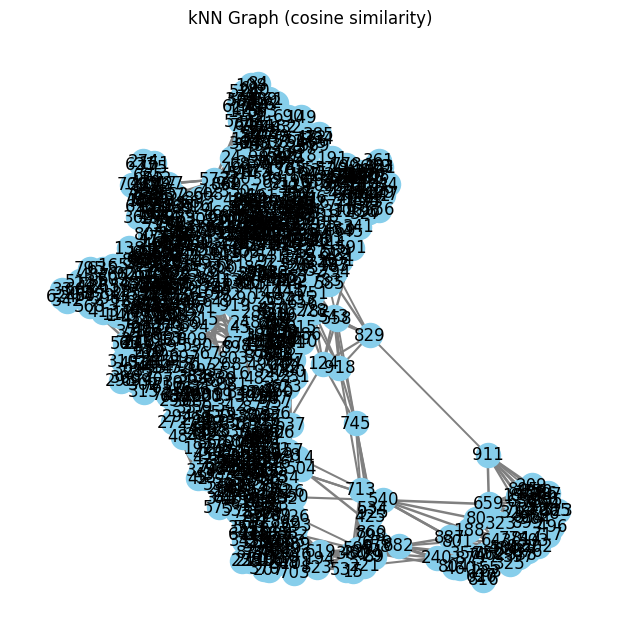

In [35]:
# ‡∏û‡∏•‡πá‡∏≠‡∏ï‡∏Å‡∏£‡∏≤‡∏ü kNN
import networkx as nx
import matplotlib.pyplot as plt

# ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡∏à‡∏≤‡∏Å edge_index_np
G = nx.Graph()
edges = list(zip(edge_index_np[0], edge_index_np[1]))
G.add_edges_from(edges)

# ‡∏ñ‡πâ‡∏≤‡∏≠‡∏¢‡∏≤‡∏Å‡πÉ‡∏ä‡πâ weight ‡πÄ‡∏õ‡πá‡∏ô‡∏Ñ‡∏ß‡∏≤‡∏°‡∏´‡∏ô‡∏≤‡∏Ç‡∏≠‡∏á‡πÄ‡∏™‡πâ‡∏ô
weights = edge_weight_np

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)  # layout ‡∏™‡∏ß‡∏¢‡∏á‡∏≤‡∏°‡∏≠‡∏±‡∏ï‡πÇ‡∏ô‡∏°‡∏±‡∏ï‡∏¥
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', width=weights * 2)
plt.title("kNN Graph (cosine similarity)")
plt.show()


node_pos: 30, color_map: 30, G.nodes: 30


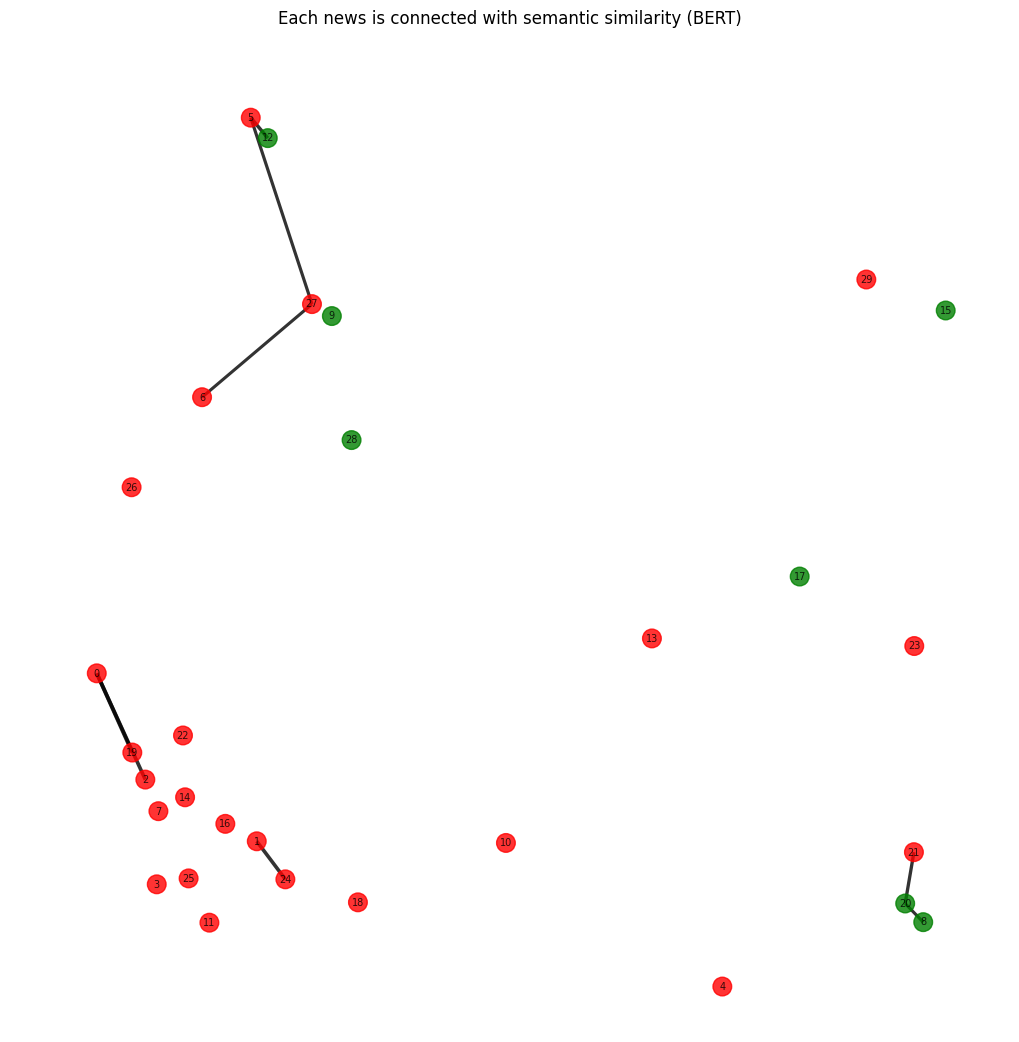

In [36]:
#--- Visualize Subgraph ---
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ‡∏™‡∏°‡∏°‡∏ï‡∏¥ plot 30 node ‡πÅ‡∏£‡∏Å
subset_idx = np.arange(30)

subset_idx_set = set(subset_idx)
sub_edges = []
sub_weights = []
for i in range(edge_index_np.shape[1]):
    src, dst = edge_index_np[0, i], edge_index_np[1, i]
    if src in subset_idx_set and dst in subset_idx_set:
        sub_edges.append((src, dst))
        sub_weights.append(edge_weight_np[i])

G = nx.Graph()
G.add_nodes_from(subset_idx)  # ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏Å‡∏±‡∏ô node ‡∏ó‡∏µ‡πà‡πÑ‡∏°‡πà‡∏°‡∏µ edge ‡∏´‡∏≤‡∏¢‡πÑ‡∏õ
G.add_edges_from([(u, v, {"weight": float(w)}) for (u, v), w in zip(sub_edges, sub_weights)])

# PCA positions
node_emb = x_np[subset_idx]
pca = PCA(n_components=2)
node_pos_np = pca.fit_transform(node_emb)
node_pos = {idx: node_pos_np[i] for i, idx in enumerate(subset_idx)}

labels_now = df.iloc[subset_idx]['label'].values
color_map = ['red' if l=='‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°' else 'green' for l in labels_now]

print(f"node_pos: {len(node_pos)}, color_map: {len(color_map)}, G.nodes: {len(G.nodes())}")

plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos=node_pos,
    node_color=color_map,
    with_labels=True,
    node_size=180,
    alpha=0.8,
    width=[G[u][v]['weight']*3 for u,v in G.edges()],
    font_size=7
)
plt.title("Each news is connected with semantic similarity (BERT)")
plt.show()

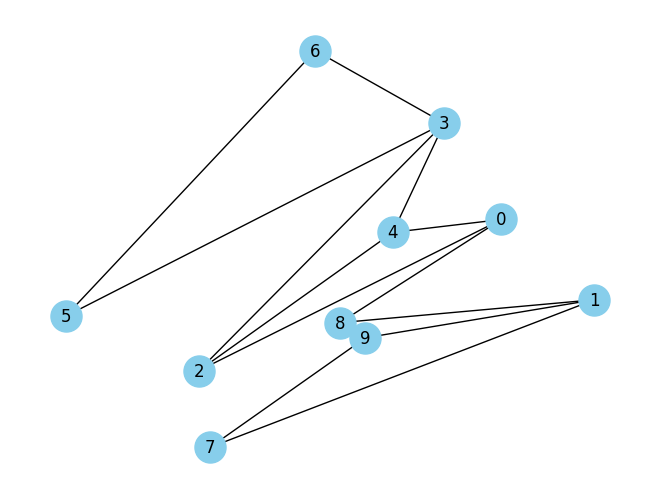

In [37]:
#--- ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü kNN ‡∏á‡πà‡∏≤‡∏¢‡πÜ ---
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (‡∏™‡∏°‡∏°‡∏ï‡∏¥‡πÅ‡∏ó‡∏ô BERT embedding 2 ‡∏°‡∏¥‡∏ï‡∏¥)
X = np.random.rand(10, 2)

# ‡∏™‡∏£‡πâ‡∏≤‡∏á kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# ‡∏ß‡∏≤‡∏î‡∏Å‡∏£‡∏≤‡∏ü
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=500)
plt.show()


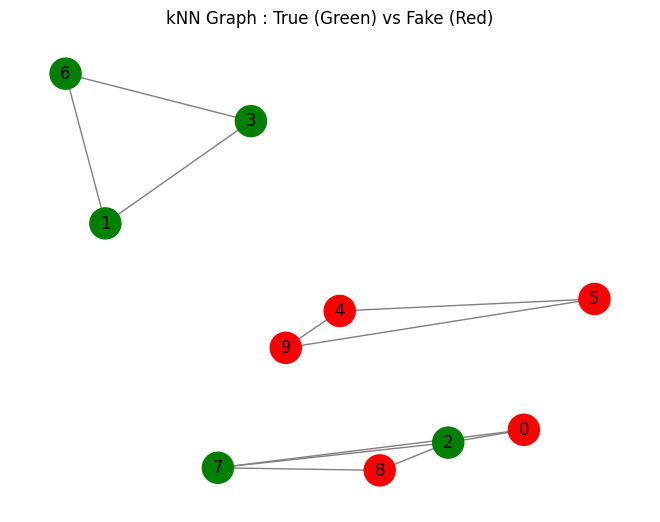

In [38]:
#--- ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü kNN ‡∏û‡∏£‡πâ‡∏≠‡∏°‡∏™‡∏µ‡πÇ‡∏´‡∏ô‡∏î‡∏à‡∏≤‡∏Å label ---
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (‡πÅ‡∏ó‡∏ô BERT embedding 2 ‡∏°‡∏¥‡∏ï‡∏¥)
X = np.random.rand(10, 2)

# label ‡∏Ç‡∏≠‡∏á‡πÇ‡∏´‡∏ô‡∏î (0=‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°, 1=‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á)
y = np.random.randint(0, 2, size=10)

# ‡∏™‡∏£‡πâ‡∏≤‡∏á kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

# map label ‚Üí ‡∏™‡∏µ
color_map = ["red" if label == 0 else "green" for label in y]

# ‡∏ß‡∏≤‡∏î‡∏Å‡∏£‡∏≤‡∏ü
pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=500, edge_color="gray")
plt.title("kNN Graph : True (Green) vs Fake (Red)")
plt.show()


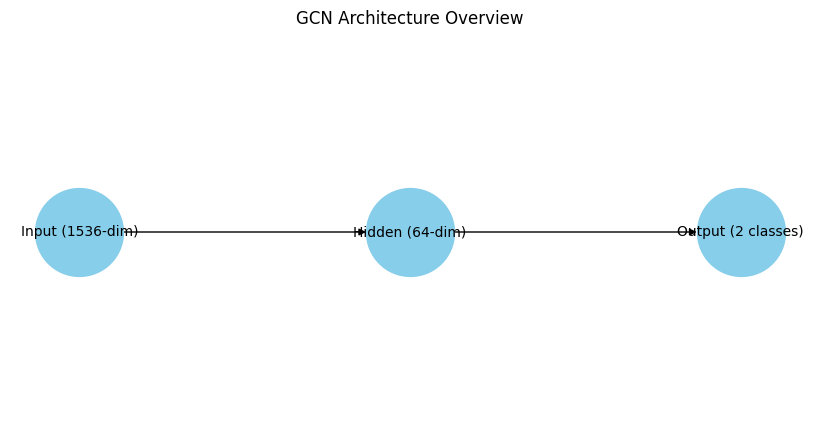

In [39]:
# ----- ‡∏ß‡∏≤‡∏î‡πÇ‡∏Ñ‡∏£‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á GCN -----
G = nx.DiGraph()

# Layer nodes
layers = {
    "Input (1536-dim)": (0, 2),
    "Hidden (64-dim)": (1, 2),
    "Output (2 classes)": (2, 2)
}

# ‡πÄ‡∏û‡∏¥‡πà‡∏°‡πÇ‡∏´‡∏ô‡∏î
for layer, pos in layers.items():
    G.add_node(layer, pos=pos)

# ‡πÄ‡∏û‡∏¥‡πà‡∏° edge
G.add_edge("Input (1536-dim)", "Hidden (64-dim)")
G.add_edge("Hidden (64-dim)", "Output (2 classes)")

# ‡∏ß‡∏≤‡∏î
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(8,4))
nx.draw(G, pos, with_labels=True, node_size=4000, 
        node_color="skyblue", font_size=10, arrows=True)
plt.title("GCN Architecture Overview")
plt.show()


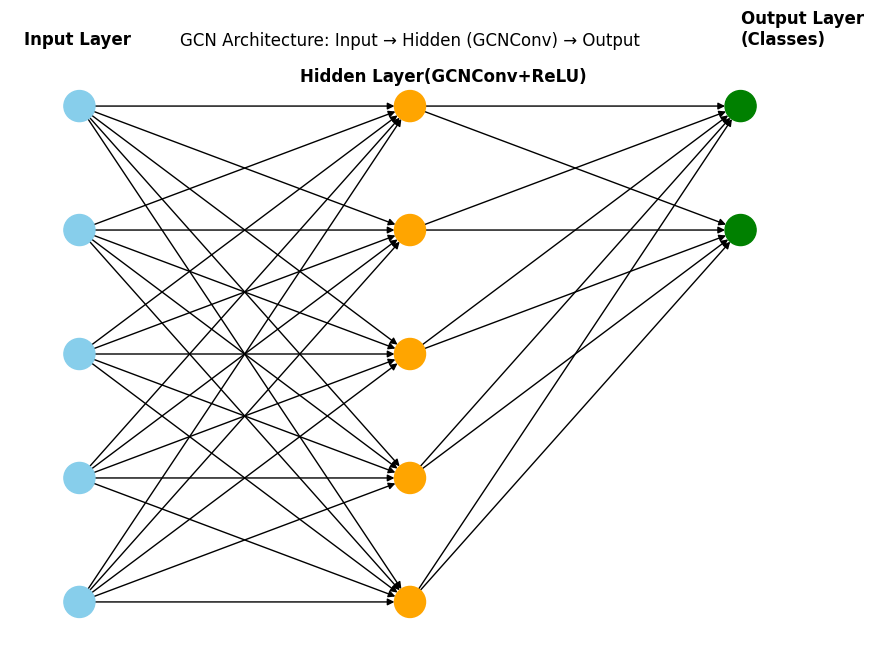

In [40]:
#----- ‡∏ß‡∏≤‡∏î‡πÇ‡∏Ñ‡∏£‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á GCN ‡πÅ‡∏ö‡∏ö‡∏•‡∏∞‡πÄ‡∏≠‡∏µ‡∏¢‡∏î -----
import matplotlib.pyplot as plt
import networkx as nx

# ‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÇ‡∏Ñ‡∏£‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á GCN: Input Layer ‚Üí Hidden Layer ‚Üí Output Layer
G = nx.DiGraph()

layers = {
    "Input (Node Features)": range(5),      # ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏°‡∏µ 5 nodes input
    "Hidden (GCNConv + ReLU)": range(5, 10),
    "Output (Node Classes)": range(10, 12)  # 2 classes: Real/Fake
}

# ‡πÄ‡∏û‡∏¥‡πà‡∏° node
for layer, nodes in layers.items():
    for node in nodes:
        G.add_node(node, layer=layer)

# ‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏° edge ‡πÅ‡∏ö‡∏ö fully-connected ‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á‡πÅ‡∏ï‡πà‡∏•‡∏∞‡∏ä‡∏±‡πâ‡∏ô
for i in layers["Input (Node Features)"]:
    for j in layers["Hidden (GCNConv + ReLU)"]:
        G.add_edge(i, j)
for i in layers["Hidden (GCNConv + ReLU)"]:
    for j in layers["Output (Node Classes)"]:
        G.add_edge(i, j)

# ‡∏à‡∏±‡∏î‡∏ï‡∏≥‡πÅ‡∏´‡∏ô‡πà‡∏á node ‡πÅ‡∏¢‡∏Å‡πÄ‡∏õ‡πá‡∏ô layers
pos = {}
x_gap = 3
for i, (layer, nodes) in enumerate(layers.items()):
    for j, node in enumerate(nodes):
        pos[node] = (i * x_gap, -j)

# map ‡∏™‡∏µ
color_map = []
for node in G.nodes():
    if node < 5:
        color_map.append("skyblue")  # input
    elif node < 10:
        color_map.append("orange")   # hidden
    else:
        color_map.append("green")    # output

# ‡∏ß‡∏≤‡∏î‡∏Å‡∏£‡∏≤‡∏ü
plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=False, node_color=color_map, node_size=500, arrows=True)

# ‡πÄ‡∏û‡∏¥‡πà‡∏° label ‡∏ä‡∏∑‡πà‡∏≠ layer (‡πÉ‡∏ä‡πâ‡∏ï‡∏≥‡πÅ‡∏´‡∏ô‡πà‡∏á‡πÄ‡∏â‡∏û‡∏≤‡∏∞)
plt.text(-0.5, 0.5, "Input Layer", fontsize=12, fontweight="bold")
plt.text(2, 0.2, "Hidden Layer(GCNConv+ReLU)", fontsize=12, fontweight="bold")
plt.text(6, 0.5, "Output Layer\n(Classes)", fontsize=12, fontweight="bold")

plt.title("GCN Architecture: Input ‚Üí Hidden (GCNConv) ‚Üí Output")
plt.axis("off")
plt.show()




--- Visualization (t-SNE & PCA) ---
Using default SEED=42
Fitting t-SNE...


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifake

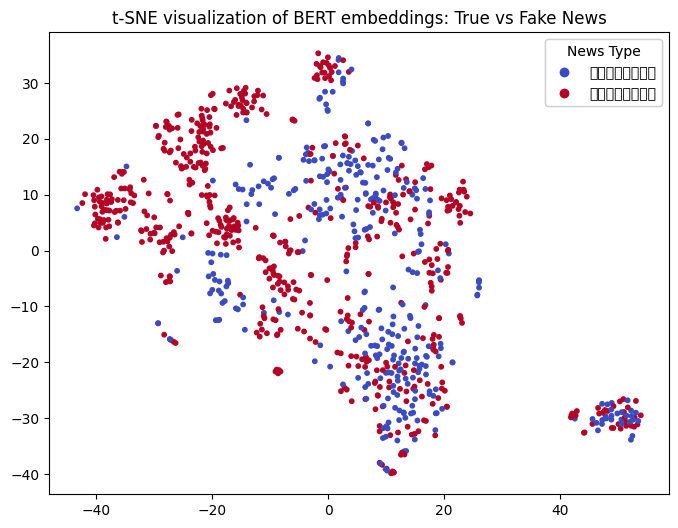

Fitting PCA...
PCA Explained Variance Ratio: Comp1=0.1628, Comp2=0.0595


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifake

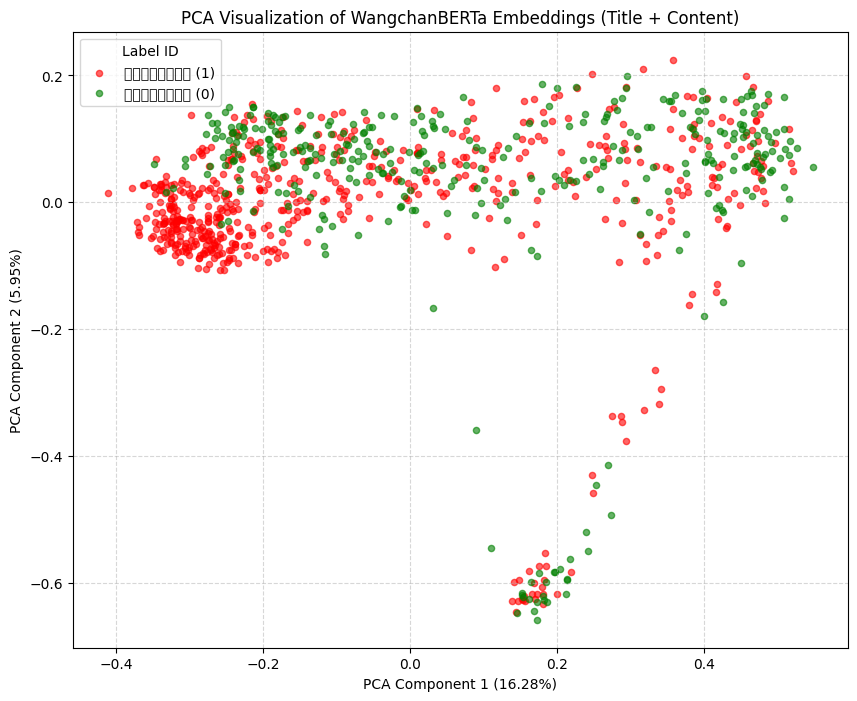

In [41]:
# --------------------------------------------------------------------
# Visualization (t-SNE & PCA) 
# --------------------------------------------------------------------
print("\n--- Visualization (t-SNE & PCA) ---")

# ‡∏Å‡∏≥‡∏´‡∏ô‡∏î SEED 
try:
    SEED
except NameError:
    SEED = 42
    print(f"Using default SEED={SEED}")

try: 
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
    print("Fitting t-SNE...")
    x_2d_tsne = tsne.fit_transform(x_np)
    
    plt.figure(figsize=(8, 6))
    # ‡πÉ‡∏ä‡πâ y_np ‡∏ó‡∏µ‡πà‡πÄ‡∏õ‡πá‡∏ô‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç‡πÅ‡∏•‡πâ‡∏ß‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏£‡∏∞‡∏ö‡∏≤‡∏¢‡∏™‡∏µ
    scatter = plt.scatter(x_2d_tsne[:, 0], x_2d_tsne[:, 1], c=y_np, cmap='coolwarm', s=10)
    plt.title("t-SNE visualization of BERT embeddings: True vs Fake News")
    
    # ‡πÄ‡∏û‡∏¥‡πà‡∏° ‡∏Ñ‡∏≥‡∏≠‡∏ò‡∏¥‡∏ö‡∏≤‡∏¢‡∏™‡∏µ ‡πÉ‡∏ä‡πâ‡∏ä‡∏∑‡πà‡∏≠ Label ‡∏à‡∏≤‡∏Å label2id

    classes = list(label2id.keys())
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á handle ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö legend
    legend1 = plt.legend(
        handles=scatter.legend_elements()[0], 
        labels=classes, 
        title="News Type"
    )
    plt.gca().add_artist(legend1)

    plt.show()
except Exception as e: 
    print(f"t-SNE plot skipped: {e}")

try:
    # PCA
   
    pca = PCA(n_components=2, random_state=42)
    print("Fitting PCA...")
    x_2d_pca = pca.fit_transform(x_np)
    
    # ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡πÉ‡∏´‡πâ‡πÅ‡∏ô‡πà‡πÉ‡∏à‡∏ß‡πà‡∏≤ '‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°' ‡πÅ‡∏•‡∏∞ '‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á' ‡∏°‡∏µ‡πÉ‡∏ô label2id
    fake_id = label2id.get('‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°', -1)
    real_id = label2id.get('‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á', -2)
    
    fake_mask = (y_np == fake_id)
    real_mask = (y_np == real_id)

    plt.figure(figsize=(10, 8))
    
    # ‡∏û‡∏•‡πá‡∏≠‡∏ï‡∏Å‡∏£‡∏≤‡∏ü‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏°
    if fake_id != -1:
        plt.scatter(x_2d_pca[fake_mask, 0], x_2d_pca[fake_mask, 1],
                    color='red', alpha=0.6, s=20, label=f'‡∏Ç‡πà‡∏≤‡∏ß‡∏õ‡∏•‡∏≠‡∏° ({fake_id})')
    
    # ‡∏û‡∏•‡πá‡∏≠‡∏ï‡∏Å‡∏£‡∏≤‡∏ü‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á
    if real_id != -2:
        plt.scatter(x_2d_pca[real_mask, 0], x_2d_pca[real_mask, 1],
                    color='green', alpha=0.6, s=20, label=f'‡∏Ç‡πà‡∏≤‡∏ß‡∏à‡∏£‡∏¥‡∏á ({real_id})')
                    
    plt.title("PCA Visualization of WangchanBERTa Embeddings (Title + Content)")
    plt.xlabel(f"PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
    
    # ‡πÅ‡∏™‡∏î‡∏á‡∏Ñ‡πà‡∏≤ explained_variance_ratio
    print(f"PCA Explained Variance Ratio: Comp1={pca.explained_variance_ratio_[0]:.4f}, Comp2={pca.explained_variance_ratio_[1]:.4f}")

    plt.legend(title="Label ID")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
except Exception as e:
    print(f"PCA plot skipped: {e}")